In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
import lightgbm as lgb
import optuna

In [2]:
# Notebook initialization
import warnings
warnings.filterwarnings('ignore')

# For displaying plots in Python scripts
plt.ion()  # Turn on interactive mode for plots

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load the data
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [4]:
# Make a copy of the original data for reference
train_original = train_data.copy()
test_original = test_data.copy()

In [5]:
# Display basic information about the dataset
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain data columns:", train_data.columns.tolist())
print("\nTest  data columns:", test_data.columns.tolist())

Train data shape: (8693, 14)
Test data shape: (4277, 13)

Train data columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

Test  data columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


In [6]:
# Check basic statistics
print("\nTrain data info:")
train_data.info()

print("\nTrain data description:")
print(train_data.describe())


Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

Train data description:
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   

In [7]:
# Check for missing values
print("\nMissing values in train data:")
missing_train = train_data.isnull().sum()
missing_percent_train = (missing_train / len(train_data)) * 100
missing_data_train = pd.concat([missing_train, missing_percent_train], axis=1, keys=['Missing Values', 'Percentage'])
print(missing_data_train)

print("\nMissing values in test data:")
missing_test = test_data.isnull().sum()
missing_percent_test = (missing_test / len(test_data)) * 100
missing_data_test = pd.concat([missing_test, missing_percent_test], axis=1, keys=['Missing Values', 'Percentage'])
print(missing_data_test)


Missing values in train data:
              Missing Values  Percentage
PassengerId                0    0.000000
HomePlanet               201    2.312205
CryoSleep                217    2.496261
Cabin                    199    2.289198
Destination              182    2.093639
Age                      179    2.059128
VIP                      203    2.335212
RoomService              181    2.082135
FoodCourt                183    2.105142
ShoppingMall             208    2.392730
Spa                      183    2.105142
VRDeck                   188    2.162660
Name                     200    2.300702
Transported                0    0.000000

Missing values in test data:
              Missing Values  Percentage
PassengerId                0    0.000000
HomePlanet                87    2.034136
CryoSleep                 93    2.174421
Cabin                    100    2.338087
Destination               92    2.151040
Age                       91    2.127660
VIP                       93    2.174


Target variable distribution:
Transported
True     50.362361
False    49.637639
Name: proportion, dtype: float64


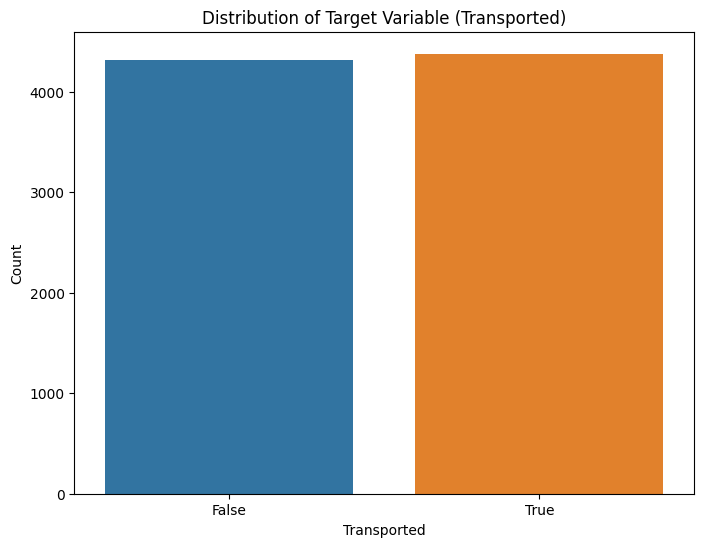

In [8]:
# Check the distribution of the target variable
print("\nTarget variable distribution:")
target_distribution = train_data['Transported'].value_counts(normalize=True) * 100
print(target_distribution)

# Visualize the target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Transported', data=train_data)
plt.title('Distribution of Target Variable (Transported)')
plt.ylabel('Count')
plt.show()

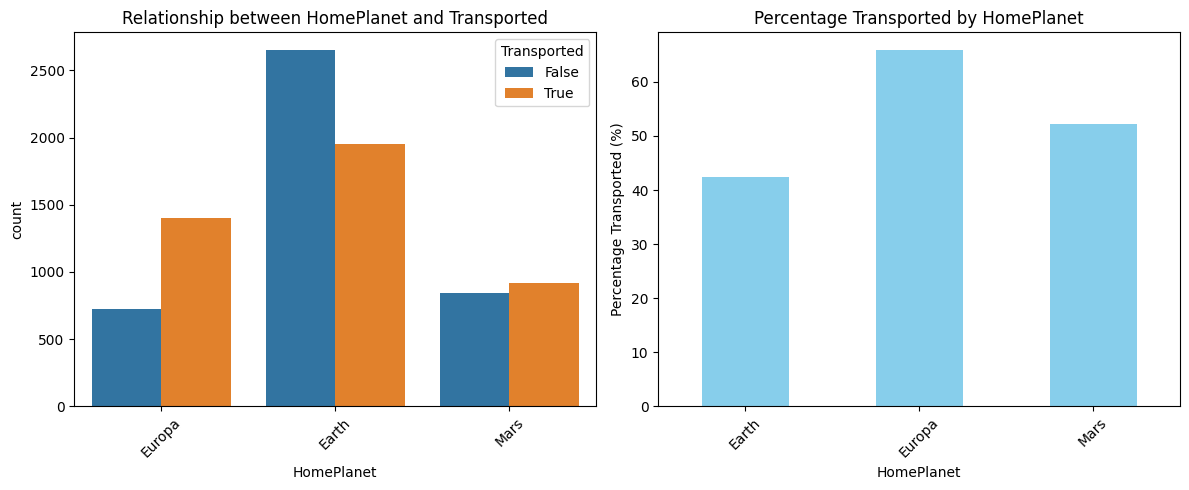

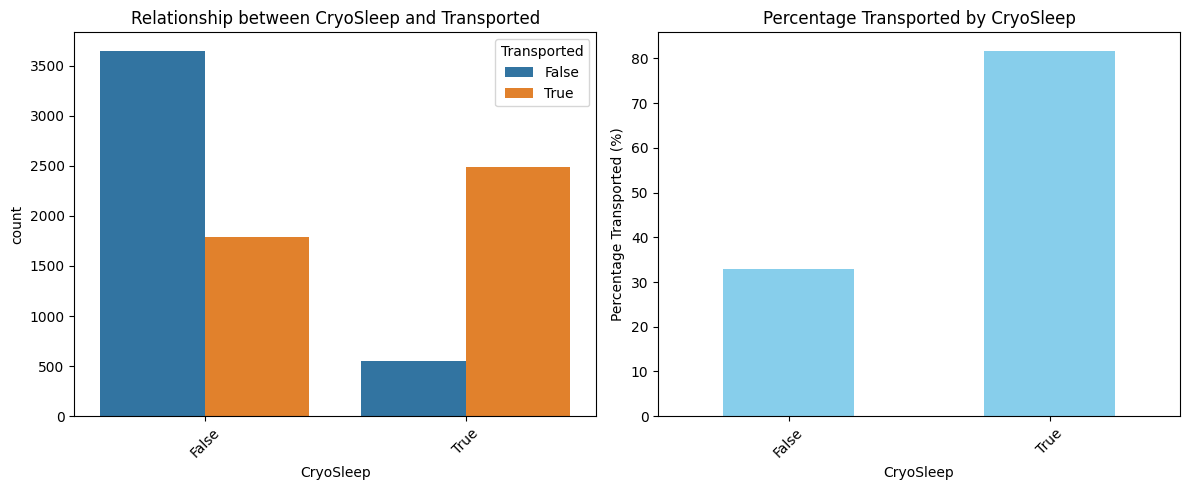

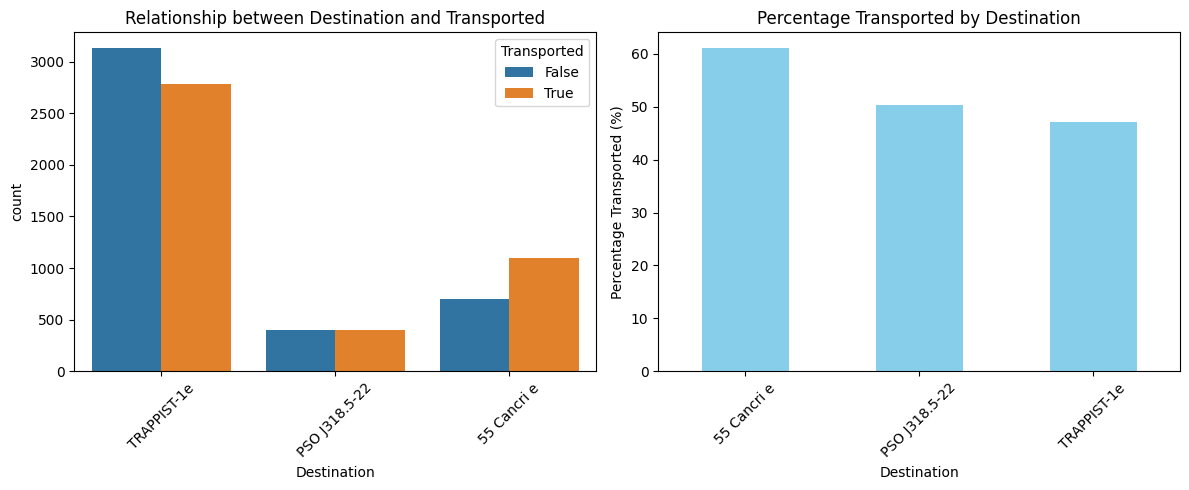

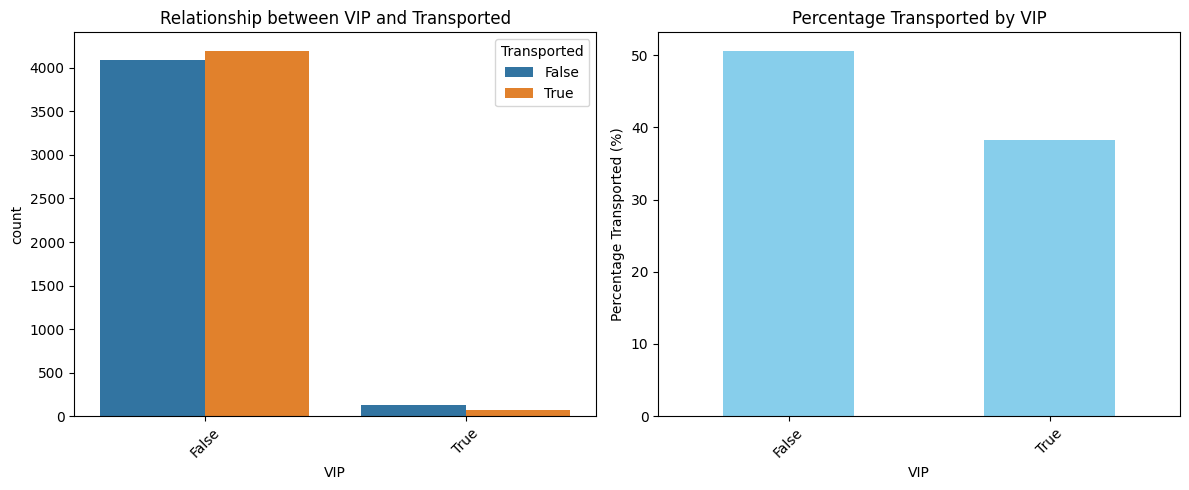

In [9]:
# Analyze categorical variables
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for feature in categorical_features:
    plt.figure(figsize=(12, 5))

    # Relationship with target
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue='Transported', data=train_data)
    plt.title(f'Relationship between {feature} and Transported')
    plt.xticks(rotation=45)

    # Percentage of transported by category
    plt.subplot(1, 2, 2)
    transport_rate = train_data.groupby(feature)['Transported'].mean() * 100
    transport_rate.plot(kind='bar', color='skyblue')
    plt.title(f'Percentage Transported by {feature}')
    plt.ylabel('Percentage Transported (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

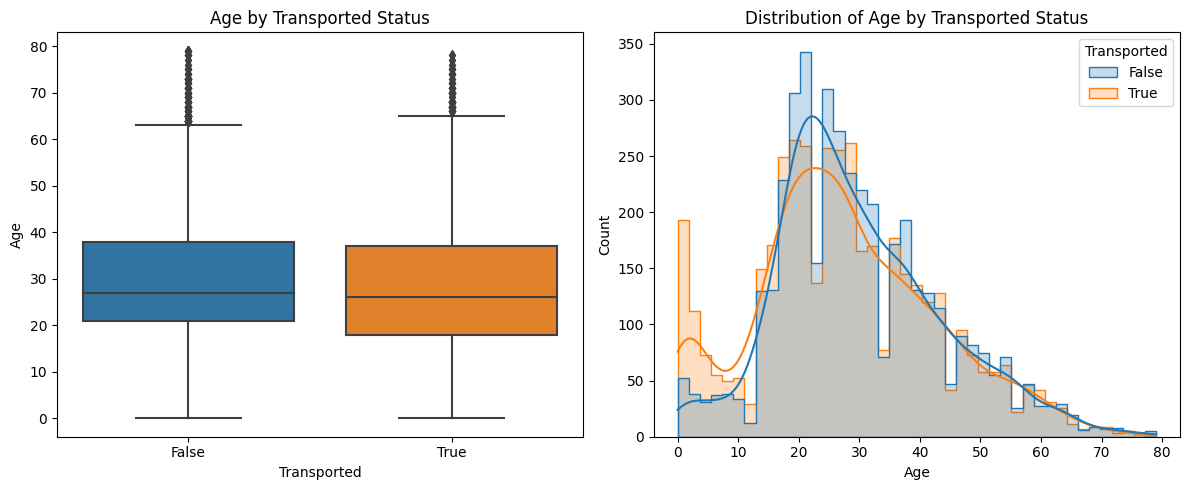

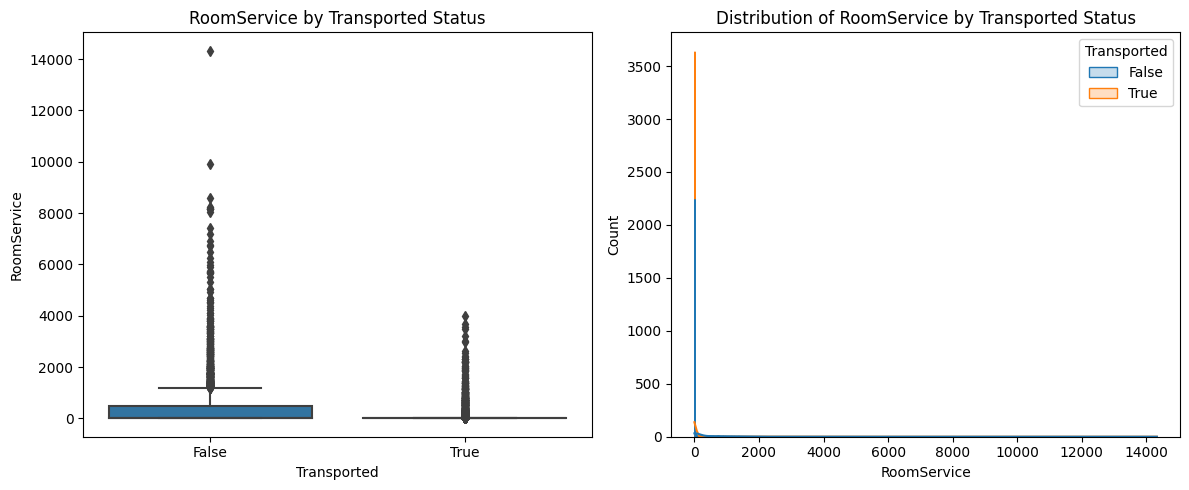

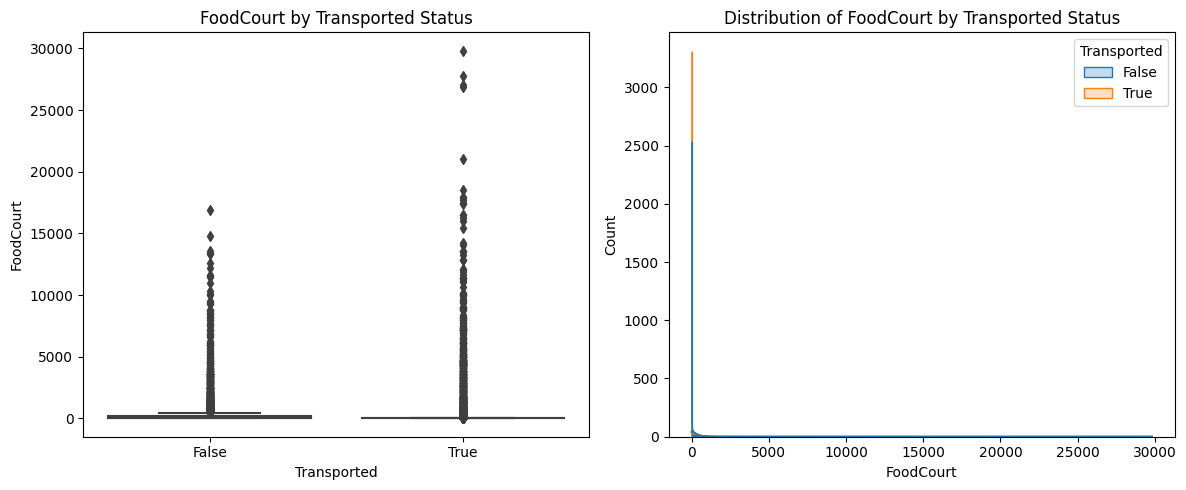

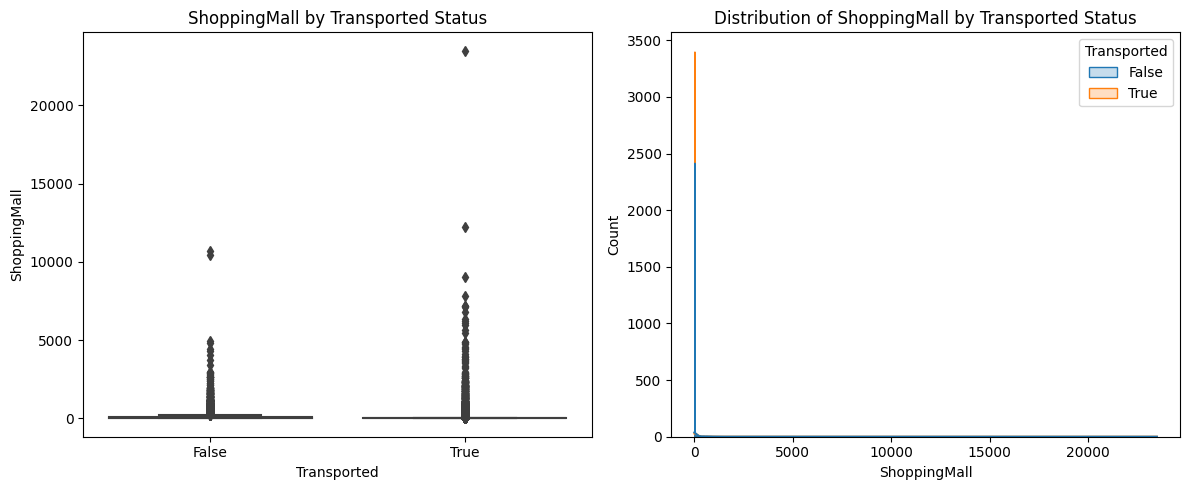

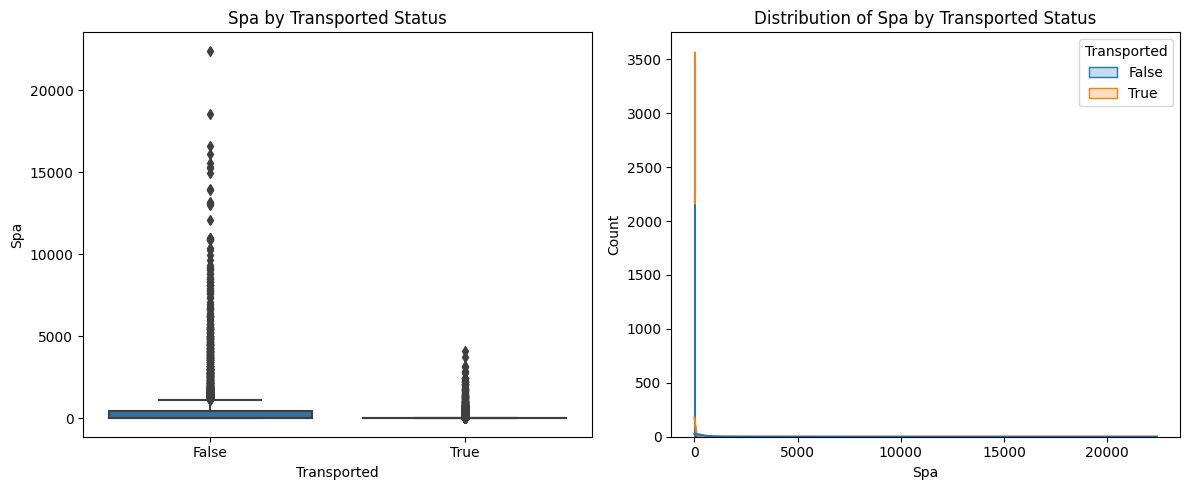

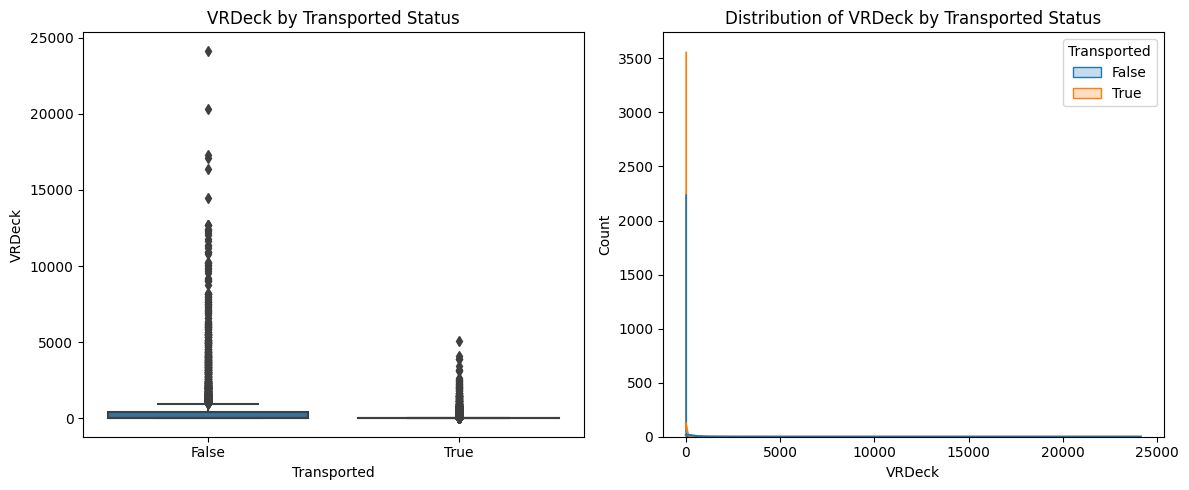

In [10]:
# Analyze numerical variables
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Distribution of numerical features
for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    # Box plot by target
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Transported', y=feature, data=train_data)
    plt.title(f'{feature} by Transported Status')

    # Histogram by target
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_data, x=feature, hue='Transported', element='step', kde=True, common_norm=False)
    plt.title(f'Distribution of {feature} by Transported Status')

    plt.tight_layout()
    plt.show()


Analyzing Cabin information...


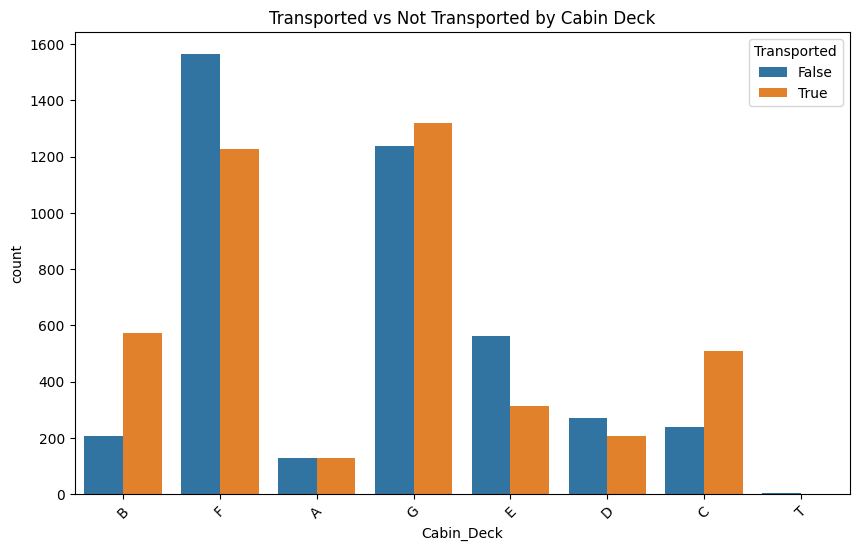

In [11]:
# Analyze cabin information
print("\nAnalyzing Cabin information...")
train_data['Cabin_Deck'] = train_data['Cabin'].str.split('/').str[0]
train_data['Cabin_Num'] = train_data['Cabin'].str.split('/').str[1]
train_data['Cabin_Side'] = train_data['Cabin'].str.split('/').str[2]

# Visualize cabin deck relationship with target
plt.figure(figsize=(10, 6))
sns.countplot(x='Cabin_Deck', hue='Transported', data=train_data)
plt.title('Transported vs Not Transported by Cabin Deck')
plt.xticks(rotation=45)
plt.show()

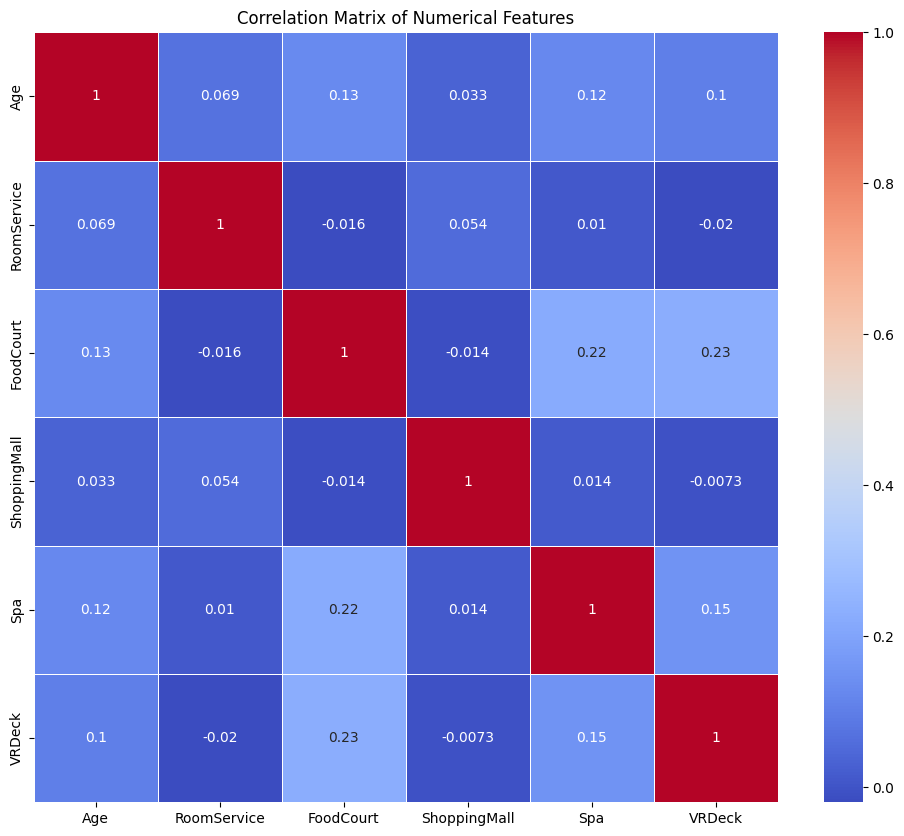

In [12]:
# Check correlations between numerical variables
plt.figure(figsize=(12, 10))
corr_matrix = train_data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


Analyzing group travel patterns...


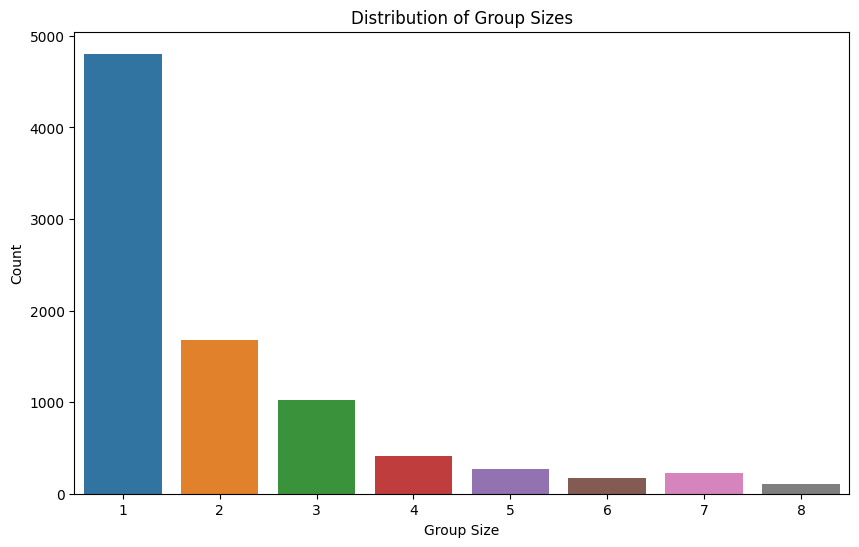

In [13]:
# Analyze group size based on PassengerId
print("\nAnalyzing group travel patterns...")
train_data['Group_Id'] = train_data['PassengerId'].str.split('_').str[0]
train_data['Group_Size'] = train_data.groupby('Group_Id')['PassengerId'].transform('count')

# Visualize group size distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Group_Size', data=train_data, order=sorted(train_data['Group_Size'].unique()))
plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Count')
plt.show()

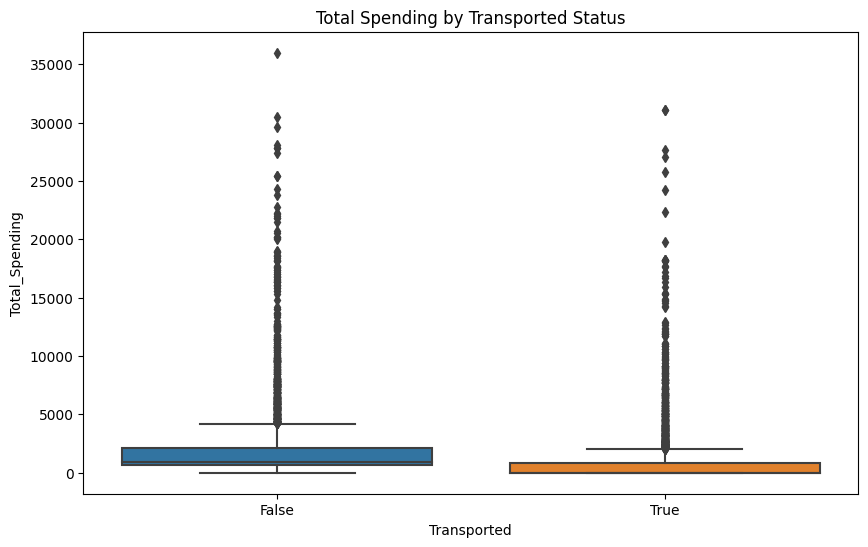

In [14]:
# Analyze total spending patterns
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_data['Total_Spending'] = train_data[spending_cols].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Transported', y='Total_Spending', data=train_data)
plt.title('Total Spending by Transported Status')
plt.show()

In [15]:
# Function to preprocess the data
def preprocess_data(data, is_training=True):
    df = data.copy()  # Copy data to avoid modifying the original
    passenger_ids = df['PassengerId']  # Extract passenger ID

    if is_training:
        y = df['Transported'].map({True: 1, False: 0})  # Save target for training data
        df.drop('Transported', axis=1, inplace=True)
    else:
        y = None

    # Process cabin information
    df['Has_Cabin'] = (~df['Cabin'].isna()).astype(int)
    cabin_parts = df['Cabin'].str.split('/', expand=True)

    if cabin_parts is not None and not cabin_parts.empty:
        if len(cabin_parts.columns) >= 3:
            df['Cabin_Deck'] = cabin_parts[0]
            df['Cabin_Num'] = pd.to_numeric(cabin_parts[1], errors='coerce')
            df['Cabin_Side'] = cabin_parts[2]
            df['Cabin_Num_Bin'] = pd.qcut(df['Cabin_Num'].fillna(df['Cabin_Num'].median()),
                                          q=10, labels=False, duplicates='drop')

    # Extract group information
    df['Group_Id'] = df['PassengerId'].str.split('_').str[0]
    df['Person_Num'] = df['PassengerId'].str.split('_').str[1].astype('int')
    df['Group_Size'] = df.groupby('Group_Id')['PassengerId'].transform('count')  # Calculate group size
    df['Is_Family'] = (df['Group_Size'] > 1).astype(int)  # Create family feature

    # Handle NaN values in spending columns
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_cols:
        df[f'Has_{col}'] = (~df[col].isna()).astype(int)

    cryo_mask = df['CryoSleep'] == True
    for col in spending_cols:
        df.loc[cryo_mask & df[col].isna(), col] = 0
        if 'HomePlanet' in df.columns and not df['HomePlanet'].isna().all():
            home_planet_medians = df.groupby('HomePlanet')[col].transform('median')
            df.loc[~cryo_mask & df[col].isna(), col] = df.loc[~cryo_mask & df[col].isna()].apply(
                lambda row: home_planet_medians[row.name] if not pd.isna(home_planet_medians[row.name]) else 0, axis=1)
        df[col] = df[col].fillna(0)

    df['Total_Spending'] = df[spending_cols].sum(axis=1)  # Calculate total spending

    # Log transform spending
    for col in spending_cols + ['Total_Spending']:
        df[f'{col}_Log'] = np.log1p(df[col])

    df['Has_Spending'] = (df['Total_Spending'] > 0).astype(int)  # Create binary flag for any spending

    # Handle missing values in categorical columns
    df['HomePlanet'] = df['HomePlanet'].fillna('Unknown')
    df['Destination'] = df['Destination'].fillna('Unknown')

    # Special handling for CryoSleep and VIP
    vip_mask = df['VIP'].isna()
    df.loc[vip_mask & (df['Total_Spending'] > df['Total_Spending'].quantile(0.75)), 'VIP'] = True
    df.loc[vip_mask, 'VIP'] = False

    cryo_mask = df['CryoSleep'].isna()
    df.loc[cryo_mask & (df['Total_Spending'] > 0), 'CryoSleep'] = False
    df.loc[cryo_mask, 'CryoSleep'] = True

    # Create interactions between features
    df['CryoSleep_VIP'] = df['CryoSleep'].astype(str) + '_' + df['VIP'].astype(str)
    df['HomePlanet_Destination'] = df['HomePlanet'].astype(str) + '_' + df['Destination'].astype(str)

    if 'Cabin_Deck' in df.columns:
        df['Deck_Destination'] = df['Cabin_Deck'].fillna('Unknown') + '_' + df['Destination']
        df['Deck_Side'] = df['Cabin_Deck'].fillna('Unknown') + '_' + df['Cabin_Side'].fillna('Unknown')

    # Ratio features
    df['Spending_Per_Person'] = df['Total_Spending'] / df['Group_Size'].replace(0, 1)
    total_mask = df['Total_Spending'] > 0
    for col in spending_cols:
        df[f'{col}_Ratio'] = 0
        if total_mask.sum() > 0:
            df.loc[total_mask, f'{col}_Ratio'] = df.loc[total_mask, col] / df.loc[total_mask, 'Total_Spending'].replace(0, 1)

    # Age processing
    if 'HomePlanet' in df.columns and not df['HomePlanet'].isna().all():
        for planet in df['HomePlanet'].unique():
            planet_mask = (df['HomePlanet'] == planet) & df['Age'].isna()
            planet_median = df.loc[df['HomePlanet'] == planet, 'Age'].median()
            if not pd.isna(planet_median):
                df.loc[planet_mask, 'Age'] = planet_median
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # Handling outliers in Age - capping at 1st and 99th percentiles
    q_low = df['Age'].quantile(0.01)
    q_high = df['Age'].quantile(0.99)
    df['Age_Capped'] = df['Age'].clip(q_low, q_high)
    
    df['Age_Group'] = pd.cut(df['Age_Capped'], bins=[0, 12, 18, 25, 35, 50, 100], labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Middle Aged', 'Senior'])
    df['Is_Child'] = (df['Age_Capped'] < 18).astype(int)
    df['Is_Senior'] = (df['Age_Capped'] > 50).astype(int)

    # Group-level statistics
    for col in ['Age'] + spending_cols:
        group_mean = df.groupby('Group_Id')[col].transform('mean')
        group_std = df.groupby('Group_Id')[col].transform('std')
        df[f'Group_{col}_Mean'] = group_mean
        df[f'Group_{col}_Std'] = group_std.fillna(0)
        df[f'{col}_Group_Deviation'] = df[col] - group_mean

    # Calculate the ratio of various expenses to total spending
    df['RoomService_Ratio'] = df['RoomService'] / df['Total_Spending'].replace(0, 1)
    df['FoodCourt_Ratio'] = df['FoodCourt'] / df['Total_Spending'].replace(0, 1)
    df['ShoppingMall_Ratio'] = df['ShoppingMall'] / df['Total_Spending'].replace(0, 1)
    df['Spa_Ratio'] = df['Spa'] / df['Total_Spending'].replace(0, 1)
    df['VRDeck_Ratio'] = df['VRDeck'] / df['Total_Spending'].replace(0, 1)
    
    # Count group members in CryoSleep
    df['Group_CryoSleep_Count'] = df.groupby('Group_Id')['CryoSleep'].transform('sum')
    
    # Count group members who are VIP
    df['Group_VIP_Count'] = df.groupby('Group_Id')['VIP'].transform('sum')
    
    # Calculate the mean age of group members
    df['Group_Age_Mean'] = df.groupby('Group_Id')['Age'].transform('mean')
    
    # Calculate the standard deviation of age in groups, fill NaN with 0
    df['Group_Age_Std'] = df.groupby('Group_Id')['Age'].transform('std').fillna(0)
    
    # Calculate the total spending of group members
    df['Group_Total_Spending_Mean'] = df.groupby('Group_Id')['Total_Spending'].transform('mean')
    
    # Calculate the ratio of total spending to group mean spending
    df['Spending_to_Group_Mean'] = df['Total_Spending'] / df['Group_Total_Spending_Mean'].replace(0, 1)
    
    # Handling outliers in spending columns
    for col in spending_cols + ['Total_Spending']:
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df[f'{col}_Capped'] = df[col].clip(q_low, q_high)

    df['CryoSleep_Age'] = df['CryoSleep'].astype(int) * df['Age']
    df['VIP_Spending'] = df['VIP'].astype(int) * df['Total_Spending']
    df['CryoSleep_Group_Size'] = df['CryoSleep'].astype(int) * df['Group_Size']
    
    # Create polynomial features for important numerical variables
    df['Age_Squared'] = df['Age'] ** 2
    df['Total_Spending_Squared'] = df['Total_Spending'] ** 2
    
    # More detailed age groups for better granularity
    df['Age_Detailed'] = pd.cut(df['Age_Capped'], 
                               bins=[0, 8, 12, 16, 20, 25, 30, 35, 40, 50, 60, 100], 
                               labels=['Infant', 'Child', 'Preteen', 'Teen', 'Young Adult', 
                                      'Adult_25_30', 'Adult_30_35', 'Adult_35_40', 
                                      'Middle_Aged', 'Senior', 'Elder'])
    
    # Create spending patterns features
    df['Spending_Pattern'] = 'None'
    # High room service and food court
    mask = (df['RoomService'] > df['RoomService'].quantile(0.75)) & (df['FoodCourt'] > df['FoodCourt'].quantile(0.75))
    df.loc[mask, 'Spending_Pattern'] = 'Room_Food'
    # High shopping and spa
    mask = (df['ShoppingMall'] > df['ShoppingMall'].quantile(0.75)) & (df['Spa'] > df['Spa'].quantile(0.75))
    df.loc[mask, 'Spending_Pattern'] = 'Shop_Spa'
    # High VRDeck
    mask = df['VRDeck'] > df['VRDeck'].quantile(0.75)
    df.loc[mask, 'Spending_Pattern'] = 'VR'
    # Balanced spending
    std_spending = df[spending_cols].std(axis=1)
    mean_spending = df[spending_cols].mean(axis=1)
    cv = std_spending / mean_spending.replace(0, 1)
    mask = (cv < 0.5) & (mean_spending > 0)
    df.loc[mask, 'Spending_Pattern'] = 'Balanced'
    
    # Spending diversity
    df['Spending_Categories'] = df[spending_cols].apply(lambda x: sum(x > 0), axis=1)
    
    # Spending concentration
    for col in spending_cols:
        df[f'{col}_Concentration'] = df[col] / df['Total_Spending'].replace(0, 1)
    
    # Group homogeneity
    for col in ['CryoSleep', 'VIP', 'HomePlanet', 'Destination']:
        if col in df.columns:
            # Calculate the most common value in each group
            most_common = df.groupby('Group_Id')[col].agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else None)
            # Map it back to each passenger
            df[f'Group_{col}_Common'] = df['Group_Id'].map(most_common)
            # A flag for whether this passenger matches the most common value
            df[f'Matches_Group_{col}'] = (df[col] == df[f'Group_{col}_Common']).astype(int)
    
    # Drop columns not used in the model
    columns_to_drop = ['PassengerId', 'Name', 'Cabin', 'Group_Id']
    df.drop(columns_to_drop, axis=1, inplace=True)

    return df, y, passenger_ids

In [16]:
# Preprocess the training and testing data
train_processed, y_train, train_passenger_ids = preprocess_data(
    train_data, is_training=True)
test_processed, _, test_passenger_ids = preprocess_data(
    test_data, is_training=False)

# Display the processed data info
print("\nProcessed training data shape:", train_processed.shape)
print("Processed testing data shape:", test_processed.shape)


Processed training data shape: (8693, 94)
Processed testing data shape: (4277, 94)


In [17]:
# Identify feature types
categorical_features = [col for col in train_processed.columns if train_processed[col].dtype == 'object' or
                        col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side',
                                'CryoSleep_VIP', 'HomePlanet_Destination', 'Age_Group', 'Deck_Destination',
                                'Deck_Side', 'Age_Detailed', 'Spending_Pattern']]

numerical_features = [
    col for col in train_processed.columns if col not in categorical_features]

print("\nCategorical features:", categorical_features)
print("\nNumerical features:", numerical_features)


Categorical features: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side', 'CryoSleep_VIP', 'HomePlanet_Destination', 'Deck_Destination', 'Deck_Side', 'Age_Group', 'Group_CryoSleep_Count', 'Group_VIP_Count', 'Age_Detailed', 'Spending_Pattern', 'Group_HomePlanet_Common', 'Group_Destination_Common']

Numerical features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num', 'Group_Size', 'Total_Spending', 'Has_Cabin', 'Cabin_Num_Bin', 'Person_Num', 'Is_Family', 'Has_RoomService', 'Has_FoodCourt', 'Has_ShoppingMall', 'Has_Spa', 'Has_VRDeck', 'RoomService_Log', 'FoodCourt_Log', 'ShoppingMall_Log', 'Spa_Log', 'VRDeck_Log', 'Total_Spending_Log', 'Has_Spending', 'Spending_Per_Person', 'RoomService_Ratio', 'FoodCourt_Ratio', 'ShoppingMall_Ratio', 'Spa_Ratio', 'VRDeck_Ratio', 'Age_Capped', 'Is_Child', 'Is_Senior', 'Group_Age_Mean', 'Group_Age_Std', 'Age_Group_Deviation', 'Group_RoomService_Mean', 'Group_RoomService_Std', 'RoomService_Group_De

In [18]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('knn_imputer', KNNImputer(n_neighbors=5)),
    ('standard_scaler', StandardScaler()),
    ('robust_scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing
X_train_full = preprocessor.fit_transform(train_processed)
X_test_transformed = preprocessor.transform(test_processed)

print(f"\nDimensions after preprocessing: {X_train_full.shape}")


Dimensions after preprocessing: (8693, 209)


In [19]:
# Perform cross-validation before feature selection to evaluate baseline performance
print("\nPerforming initial cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
base_model = lgb.LGBMClassifier(random_state=RANDOM_STATE)

cv_scores = cross_val_score(base_model, X_train_full, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Initial CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Performing initial cross-validation...
Initial CV Scores: [0.81483611 0.81253594 0.80391029 0.82508631 0.79516686]
Mean CV Score: 0.8103 (+/- 0.0203)


In [20]:
# Feature selection to reduce dimensionality and prevent overfitting
print("\nPerforming feature selection...")
k_best = min(100, X_train_full.shape[1])  # Select top k features
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_full, y_train)
X_test_selected = selector.transform(X_test_transformed)

print(f"Dimensions after feature selection: {X_train_selected.shape}")


Performing feature selection...
Dimensions after feature selection: (8693, 100)


In [21]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

# Convert y values to numpy arrays for consistency
y_train_array = np.array(y_train)
y_val_np = np.array(y_val)

print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (6954, 100)
Validation set shape: (1739, 100)


In [22]:
# Define the objective function for Optuna optimization with overfitting prevention
def objective_lgb(trial):
    param = {
        'objective': 'binary',                # Binary classification
        'metric': ['binary_logloss', 'auc'],  # Binary log loss and AUC metric for evaluation
        'verbosity': -1,                      # Reduce verbosity
        'boosting_type': 'gbdt',              # Gradient Boosting Decision Tree

        # Regularization parameters - for reducing overfitting
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-9, 1e-5, log=True),  # L1 regularization - reduced range
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-9, 1e-5, log=True),  # L2 regularization - reduced range

        # Tree structure parameters - balance between model complexity and generalization
        'num_leaves': trial.suggest_int('num_leaves', 2, 31),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        
        # Learning parameters - control training process
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        
        # Additional fine-tuning parameters
        'min_split_gain': trial.suggest_float('min_split_gain', 0.01, 0.1),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 200000, 300000),
        'path_smooth': trial.suggest_float('path_smooth', 0.0, 0.2),
        'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),
        'cat_l2': trial.suggest_float('cat_l2', 1.0, 20.0),
        'max_cat_to_onehot': trial.suggest_int('max_cat_to_onehot', 1, 10),
        
        # Class balancing parameters
        'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.7, 1.0),
        'neg_bagging_fraction': trial.suggest_float('neg_bagging_fraction', 0.7, 1.0),
        'max_delta_step': trial.suggest_float('max_delta_step', 0.1, 2.0)
    }

    # Enhanced Cross-Validation with multiple metrics
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores_accuracy = []
    cv_scores_auc = []
    cv_scores_f1 = []

    for train_idx, valid_idx in cv_outer.split(X_train, y_train_array):
        X_train_cv, X_valid_cv = X_train[train_idx], X_train[valid_idx]
        y_train_cv, y_valid_cv = y_train_array[train_idx], y_train_array[valid_idx]

        train_data = lgb.Dataset(X_train_cv, label=y_train_cv)
        valid_data = lgb.Dataset(X_valid_cv, label=y_valid_cv, reference=train_data)
        
        # Early stopping callback
        callbacks = [
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ]

        # Train the model
        model = lgb.train(
            param,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=5000,
            callbacks=callbacks
        )

        # Make predictions
        y_pred = model.predict(X_valid_cv)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate multiple metrics
        accuracy = accuracy_score(y_valid_cv, y_pred_binary)
        auc = roc_auc_score(y_valid_cv, y_pred)
        f1 = f1_score(y_valid_cv, y_pred_binary)

        cv_scores_accuracy.append(accuracy)
        cv_scores_auc.append(auc)
        cv_scores_f1.append(f1)
        
    # Calculate mean scores
    mean_accuracy = np.mean(cv_scores_accuracy)
    mean_auc = np.mean(cv_scores_auc)
    mean_f1 = np.mean(cv_scores_f1)

    # Use a weighted combination of metrics for optimization
    final_score = (mean_accuracy * 0.80 + mean_auc * 0.10 + mean_f1 * 0.10)

    # Store additional metrics in the trial
    trial.set_user_attr('accuracy', mean_accuracy)
    trial.set_user_attr('auc', mean_auc)
    trial.set_user_attr('f1', mean_f1)

    return final_score

In [23]:
# Run Optuna optimization for LightGBM
print("\nOptimizing LightGBM hyperparameters with enhanced cross-validation...")
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(objective_lgb, n_trials=50)

print("\nBest trial:")
print("\tValue: ", lgb_study.best_trial.value)
print("\tAccuracy: ", lgb_study.best_trial.user_attrs['accuracy'])
print("\tAUC: ", lgb_study.best_trial.user_attrs['auc'])
print("\tF1: ", lgb_study.best_trial.user_attrs['f1'])
print("\tParams: ")
for key, value in lgb_study.best_trial.params.items():
    print(f"\t{key}: {value}")

[I 2025-03-24 04:20:19,391] A new study created in memory with name: no-name-1be95c35-13e4-42f1-8255-d58590944170



Optimizing LightGBM hyperparameters with enhanced cross-validation...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.387495	valid_0's auc: 0.901993
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.389816	valid_0's auc: 0.900105
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.397668	valid_0's auc: 0.898189
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.407207	valid_0's auc: 0.891851
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:20:27,828] Trial 0 finished with value: 0.8161632725076648 and parameters: {'lambda_l1': 1.385705171643365e-06, 'lambda_l2': 2.625803820406031e-06, 'num_leaves': 15, 'feature_fraction': 0.9246079963810916, 'bagging_fraction': 0.9921824962830925, 'bagging_freq': 6, 'min_child_samples': 180, 'max_depth': 13, 'learning_rate': 0.03200124101887109, 'n_estimators': 4606, 'min_data_in_leaf': 69, 'min_split_gain': 0.037636932347805296, 'max_bin': 279, 'subsample_for_bin': 277183, 'path_smooth': 0.0476388077030904, 'cat_smooth': 72.207301802205, 'cat_l2': 5.441257722128196, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.8253856657644848, 'neg_bagging_fraction': 0.8242394072089734, 'max_delta_step': 0.7766784472794621}. Best is trial 0 with value: 0.8161632725076648.


Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.39711	valid_0's auc: 0.897774
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	valid_0's binary_logloss: 0.390257	valid_0's auc: 0.902168
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.399592	valid_0's auc: 0.895915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.412404	valid_0's auc: 0.891189
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.4104	valid_0's auc: 0.891418
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:20:43,634] Trial 1 finished with value: 0.8128112831634459 and parameters: {'lambda_l1': 3.903649998892838e-08, 'lambda_l2': 2.8384452254961985e-07, 'num_leaves': 31, 'feature_fraction': 0.9342179478983692, 'bagging_fraction': 0.9605189065684033, 'bagging_freq': 9, 'min_child_samples': 279, 'max_depth': 10, 'learning_rate': 0.048319767016692224, 'n_estimators': 3795, 'min_data_in_leaf': 15, 'min_split_gain': 0.0882515749758712, 'max_bin': 253, 'subsample_for_bin': 221600, 'path_smooth': 0.10254972958283054, 'cat_smooth': 79.8197410495898, 'cat_l2': 8.208515449893843, 'max_cat_to_onehot': 10, 'pos_bagging_fraction': 0.9600121939616068, 'neg_bagging_fraction': 0.9537733149404755, 'max_delta_step': 0.2469180209452589}. Best is trial 0 with value: 0.8161632725076648.


Early stopping, best iteration is:
[431]	valid_0's binary_logloss: 0.405196	valid_0's auc: 0.89428
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.392741	valid_0's auc: 0.901413
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.396964	valid_0's auc: 0.901367
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.399454	valid_0's auc: 0.898693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.413971	valid_0's auc: 0.890087
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:20:50,739] Trial 2 finished with value: 0.8140690113912277 and parameters: {'lambda_l1': 1.058380201616312e-08, 'lambda_l2': 4.264091721449987e-08, 'num_leaves': 13, 'feature_fraction': 0.8242355297823641, 'bagging_fraction': 0.7912966259200879, 'bagging_freq': 10, 'min_child_samples': 147, 'max_depth': 14, 'learning_rate': 0.04164972041450186, 'n_estimators': 3099, 'min_data_in_leaf': 100, 'min_split_gain': 0.02535777903110992, 'max_bin': 256, 'subsample_for_bin': 218191, 'path_smooth': 0.17665414330257478, 'cat_smooth': 60.11008798388756, 'cat_l2': 15.832588456430592, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.9686703245651899, 'neg_bagging_fraction': 0.7089192916893057, 'max_delta_step': 1.6444887419268874}. Best is trial 0 with value: 0.8161632725076648.


Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.407489	valid_0's auc: 0.896033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[756]	valid_0's binary_logloss: 0.401512	valid_0's auc: 0.897538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[671]	valid_0's binary_logloss: 0.406272	valid_0's auc: 0.895276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[701]	valid_0's binary_logloss: 0.414303	valid_0's auc: 0.891453
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[833]	valid_0's binary_logloss: 0.415953	valid_0's auc: 0.890337
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:20:56,854] Trial 3 finished with value: 0.8133694269728654 and parameters: {'lambda_l1': 2.3594026556559163e-06, 'lambda_l2': 6.066983456303191e-06, 'num_leaves': 3, 'feature_fraction': 0.9482544046174216, 'bagging_fraction': 0.9816150214910443, 'bagging_freq': 7, 'min_child_samples': 279, 'max_depth': 11, 'learning_rate': 0.07121450001650594, 'n_estimators': 4468, 'min_data_in_leaf': 24, 'min_split_gain': 0.040887198726967514, 'max_bin': 290, 'subsample_for_bin': 291736, 'path_smooth': 0.033629338817016734, 'cat_smooth': 58.459266070502636, 'cat_l2': 19.682648351840093, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.8279248315712758, 'neg_bagging_fraction': 0.9653550475955484, 'max_delta_step': 0.65766483671092}. Best is trial 0 with value: 0.8161632725076648.


Early stopping, best iteration is:
[518]	valid_0's binary_logloss: 0.410774	valid_0's auc: 0.89331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[569]	valid_0's binary_logloss: 0.385994	valid_0's auc: 0.901939
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	valid_0's binary_logloss: 0.389377	valid_0's auc: 0.899519
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[636]	valid_0's binary_logloss: 0.39644	valid_0's auc: 0.898299
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[475]	valid_0's binary_logloss: 0.400903	valid_0's auc: 0.895157
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:21:15,757] Trial 4 finished with value: 0.8159714603715569 and parameters: {'lambda_l1': 1.6766793544490253e-06, 'lambda_l2': 3.7219370655459145e-09, 'num_leaves': 21, 'feature_fraction': 0.9514078438794981, 'bagging_fraction': 0.7913017306096509, 'bagging_freq': 6, 'min_child_samples': 164, 'max_depth': 11, 'learning_rate': 0.011251857200596734, 'n_estimators': 2827, 'min_data_in_leaf': 16, 'min_split_gain': 0.01478647772758699, 'max_bin': 245, 'subsample_for_bin': 273997, 'path_smooth': 0.06688463045034532, 'cat_smooth': 63.48155843605601, 'cat_l2': 2.4751901667825194, 'max_cat_to_onehot': 9, 'pos_bagging_fraction': 0.9135864978559385, 'neg_bagging_fraction': 0.9445000095741097, 'max_delta_step': 1.3682731926196323}. Best is trial 0 with value: 0.8161632725076648.


Early stopping, best iteration is:
[575]	valid_0's binary_logloss: 0.390862	valid_0's auc: 0.900608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[444]	valid_0's binary_logloss: 0.400852	valid_0's auc: 0.897319
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[473]	valid_0's binary_logloss: 0.401759	valid_0's auc: 0.898284
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.411275	valid_0's auc: 0.893124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's binary_logloss: 0.415892	valid_0's auc: 0.89044
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:21:30,975] Trial 5 finished with value: 0.8132370803321864 and parameters: {'lambda_l1': 4.9960077670494016e-08, 'lambda_l2': 1.0091382454256849e-07, 'num_leaves': 28, 'feature_fraction': 0.9175765982425508, 'bagging_fraction': 0.7396894798243552, 'bagging_freq': 2, 'min_child_samples': 146, 'max_depth': 10, 'learning_rate': 0.05277433320986962, 'n_estimators': 4235, 'min_data_in_leaf': 51, 'min_split_gain': 0.04786313203910779, 'max_bin': 239, 'subsample_for_bin': 256561, 'path_smooth': 0.04140812235574492, 'cat_smooth': 42.47777604853342, 'cat_l2': 13.996314932730884, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.9642668842979986, 'neg_bagging_fraction': 0.7174748374095976, 'max_delta_step': 0.19296929571763266}. Best is trial 0 with value: 0.8161632725076648.


Early stopping, best iteration is:
[452]	valid_0's binary_logloss: 0.409659	valid_0's auc: 0.895319
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	valid_0's binary_logloss: 0.391271	valid_0's auc: 0.90066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[621]	valid_0's binary_logloss: 0.395311	valid_0's auc: 0.900402
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.408499	valid_0's auc: 0.893281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's binary_logloss: 0.409821	valid_0's auc: 0.892671
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:21:35,744] Trial 6 finished with value: 0.8175727259121044 and parameters: {'lambda_l1': 6.110725904822206e-07, 'lambda_l2': 1.1284916589370482e-07, 'num_leaves': 5, 'feature_fraction': 0.74173156365801, 'bagging_fraction': 0.724259385321766, 'bagging_freq': 1, 'min_child_samples': 131, 'max_depth': 15, 'learning_rate': 0.08885424401861174, 'n_estimators': 1728, 'min_data_in_leaf': 17, 'min_split_gain': 0.09332898386753626, 'max_bin': 251, 'subsample_for_bin': 269905, 'path_smooth': 0.14763447681313555, 'cat_smooth': 46.34091574595297, 'cat_l2': 1.490779326425573, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9851516515871679, 'neg_bagging_fraction': 0.7745378446046114, 'max_delta_step': 0.7545633838266649}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[363]	valid_0's binary_logloss: 0.399825	valid_0's auc: 0.898853
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1355]	valid_0's binary_logloss: 0.422922	valid_0's auc: 0.887298
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1355]	valid_0's binary_logloss: 0.421762	valid_0's auc: 0.890403
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.668999	valid_0's auc: 0.817011
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1355]	valid_0's binary_logloss: 0.437733	valid_0's auc: 0.880626
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:21:58,695] Trial 7 finished with value: 0.8017855995376575 and parameters: {'lambda_l1': 9.50602083013548e-06, 'lambda_l2': 1.1959505049151452e-09, 'num_leaves': 25, 'feature_fraction': 0.9326993005405713, 'bagging_fraction': 0.9199249522944482, 'bagging_freq': 6, 'min_child_samples': 161, 'max_depth': 10, 'learning_rate': 0.00840302352608688, 'n_estimators': 1355, 'min_data_in_leaf': 31, 'min_split_gain': 0.02170301907865188, 'max_bin': 260, 'subsample_for_bin': 201092, 'path_smooth': 0.086190406600816, 'cat_smooth': 75.16289349151428, 'cat_l2': 2.1350233554860782, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.7272599740984677, 'neg_bagging_fraction': 0.7342060279556554, 'max_delta_step': 0.2126019317647817}. Best is trial 6 with value: 0.8175727259121044.


Did not meet early stopping. Best iteration is:
[1355]	valid_0's binary_logloss: 0.423335	valid_0's auc: 0.889307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.388408	valid_0's auc: 0.901902
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.387909	valid_0's auc: 0.901081
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.400861	valid_0's auc: 0.896316
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.399956	valid_0's auc: 0.895673
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:04,617] Trial 8 finished with value: 0.8150272726839171 and parameters: {'lambda_l1': 2.466848919114696e-07, 'lambda_l2': 1.2664025517946225e-06, 'num_leaves': 26, 'feature_fraction': 0.7899803312960937, 'bagging_fraction': 0.845485029219229, 'bagging_freq': 4, 'min_child_samples': 164, 'max_depth': 14, 'learning_rate': 0.055762654731716384, 'n_estimators': 3902, 'min_data_in_leaf': 25, 'min_split_gain': 0.025141030979041835, 'max_bin': 255, 'subsample_for_bin': 289742, 'path_smooth': 0.16259519984426785, 'cat_smooth': 18.153488899154937, 'cat_l2': 6.303957195255034, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.7058421682901541, 'neg_bagging_fraction': 0.7621544577861796, 'max_delta_step': 1.379935590781984}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.392895	valid_0's auc: 0.899615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	valid_0's binary_logloss: 0.395271	valid_0's auc: 0.899686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	valid_0's binary_logloss: 0.397811	valid_0's auc: 0.897742
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[600]	valid_0's binary_logloss: 0.406341	valid_0's auc: 0.894271
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	valid_0's binary_logloss: 0.413452	valid_0's auc: 0.889148
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:20,753] Trial 9 finished with value: 0.8147689976278927 and parameters: {'lambda_l1': 7.116639698038889e-08, 'lambda_l2': 1.68585998644124e-09, 'num_leaves': 21, 'feature_fraction': 0.9668210932875405, 'bagging_fraction': 0.9384886287645968, 'bagging_freq': 8, 'min_child_samples': 250, 'max_depth': 13, 'learning_rate': 0.03040616989979024, 'n_estimators': 4439, 'min_data_in_leaf': 75, 'min_split_gain': 0.06614050991531407, 'max_bin': 288, 'subsample_for_bin': 211979, 'path_smooth': 0.01900730923155567, 'cat_smooth': 26.66606538951452, 'cat_l2': 10.462429454695721, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.7745342212878268, 'neg_bagging_fraction': 0.7274535453308832, 'max_delta_step': 0.23843725292048062}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[625]	valid_0's binary_logloss: 0.405829	valid_0's auc: 0.894799
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[831]	valid_0's binary_logloss: 0.421398	valid_0's auc: 0.887742
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	valid_0's binary_logloss: 0.426867	valid_0's auc: 0.88745
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	valid_0's binary_logloss: 0.431113	valid_0's auc: 0.883065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[810]	valid_0's binary_logloss: 0.441269	valid_0's auc: 0.87756
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:26,322] Trial 10 finished with value: 0.8048876440482133 and parameters: {'lambda_l1': 1.2344127741012508e-09, 'lambda_l2': 1.565894060528476e-08, 'num_leaves': 2, 'feature_fraction': 0.7034420276348918, 'bagging_fraction': 0.7131729423151626, 'bagging_freq': 1, 'min_child_samples': 106, 'max_depth': 15, 'learning_rate': 0.09836136877486762, 'n_estimators': 1181, 'min_data_in_leaf': 44, 'min_split_gain': 0.09932104083763443, 'max_bin': 209, 'subsample_for_bin': 251486, 'path_smooth': 0.1352645820342819, 'cat_smooth': 93.9578884224467, 'cat_l2': 12.879140531825971, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.893405225710463, 'neg_bagging_fraction': 0.8357846854557701, 'max_delta_step': 0.884887728230357}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[593]	valid_0's binary_logloss: 0.423067	valid_0's auc: 0.888032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.388174	valid_0's auc: 0.902105
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.390196	valid_0's auc: 0.900392
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.398103	valid_0's auc: 0.898211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.408026	valid_0's auc: 0.891129
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:30,138] Trial 11 finished with value: 0.8166553852679823 and parameters: {'lambda_l1': 5.224170878447778e-07, 'lambda_l2': 8.50721002240797e-06, 'num_leaves': 9, 'feature_fraction': 0.7193926700938325, 'bagging_fraction': 0.8871921959118286, 'bagging_freq': 4, 'min_child_samples': 210, 'max_depth': 15, 'learning_rate': 0.09502840584522634, 'n_estimators': 2132, 'min_data_in_leaf': 73, 'min_split_gain': 0.07899675614064046, 'max_bin': 277, 'subsample_for_bin': 273228, 'path_smooth': 0.12249847956836758, 'cat_smooth': 39.490060194914676, 'cat_l2': 4.723549549398383, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.8314089129276263, 'neg_bagging_fraction': 0.8172386365621891, 'max_delta_step': 0.7148271858053095}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.399672	valid_0's auc: 0.896112
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.394214	valid_0's auc: 0.899371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.390595	valid_0's auc: 0.900888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.403484	valid_0's auc: 0.895733
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 0.412197	valid_0's auc: 0.889152
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:33,684] Trial 12 finished with value: 0.81637742945139 and parameters: {'lambda_l1': 4.0351420624641216e-07, 'lambda_l2': 5.003432256248607e-07, 'num_leaves': 9, 'feature_fraction': 0.7170729682624104, 'bagging_fraction': 0.8728804849862588, 'bagging_freq': 3, 'min_child_samples': 217, 'max_depth': 15, 'learning_rate': 0.0987442182179493, 'n_estimators': 2025, 'min_data_in_leaf': 72, 'min_split_gain': 0.07190523568822438, 'max_bin': 226, 'subsample_for_bin': 267360, 'path_smooth': 0.12731835027933683, 'cat_smooth': 38.858357906817226, 'cat_l2': 1.0019873752526003, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.8832757524766093, 'neg_bagging_fraction': 0.7894666202739256, 'max_delta_step': 0.5596593102307388}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.400138	valid_0's auc: 0.897241
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.39079	valid_0's auc: 0.900147
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.392631	valid_0's auc: 0.899477
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.400009	valid_0's auc: 0.897719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.412236	valid_0's auc: 0.889706
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:37,266] Trial 13 finished with value: 0.8146125082334464 and parameters: {'lambda_l1': 3.625352831687437e-07, 'lambda_l2': 1.138774112213216e-08, 'num_leaves': 8, 'feature_fraction': 0.7629218368786949, 'bagging_fraction': 0.8869411596910193, 'bagging_freq': 4, 'min_child_samples': 212, 'max_depth': 15, 'learning_rate': 0.08150056928976317, 'n_estimators': 2165, 'min_data_in_leaf': 91, 'min_split_gain': 0.08136102835945835, 'max_bin': 273, 'subsample_for_bin': 237476, 'path_smooth': 0.19893741370033696, 'cat_smooth': 42.70309386918207, 'cat_l2': 5.3411660932759695, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.7891836148308685, 'neg_bagging_fraction': 0.8947855954457747, 'max_delta_step': 1.1219079142724697}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.399989	valid_0's auc: 0.896582
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.387591	valid_0's auc: 0.902589
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.387576	valid_0's auc: 0.901244
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.399632	valid_0's auc: 0.89655
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.401492	valid_0's auc: 0.894912
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:41,042] Trial 14 finished with value: 0.8175618147898918 and parameters: {'lambda_l1': 8.002611553926719e-07, 'lambda_l2': 9.356918012010457e-06, 'num_leaves': 8, 'feature_fraction': 0.7620892633089748, 'bagging_fraction': 0.8244294208538786, 'bagging_freq': 1, 'min_child_samples': 107, 'max_depth': 14, 'learning_rate': 0.08287852738335612, 'n_estimators': 1973, 'min_data_in_leaf': 61, 'min_split_gain': 0.09911525352403694, 'max_bin': 270, 'subsample_for_bin': 299012, 'path_smooth': 0.12532017500903553, 'cat_smooth': 32.47653272438893, 'cat_l2': 4.419200388634378, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.859961067559931, 'neg_bagging_fraction': 0.8692444805456875, 'max_delta_step': 1.0676863540724773}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.39823	valid_0's auc: 0.896714
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.389909	valid_0's auc: 0.900872
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	valid_0's binary_logloss: 0.389259	valid_0's auc: 0.901799
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's binary_logloss: 0.40146	valid_0's auc: 0.89541
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.401651	valid_0's auc: 0.894313
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:45,885] Trial 15 finished with value: 0.8163315317874591 and parameters: {'lambda_l1': 8.7595402516238e-06, 'lambda_l2': 1.946615270512405e-07, 'num_leaves': 6, 'feature_fraction': 0.8584433938951728, 'bagging_fraction': 0.7903477824758106, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 14, 'learning_rate': 0.07555762463015715, 'n_estimators': 1651, 'min_data_in_leaf': 41, 'min_split_gain': 0.09669298035900234, 'max_bin': 300, 'subsample_for_bin': 299918, 'path_smooth': 0.15240650962780627, 'cat_smooth': 12.477124232353347, 'cat_l2': 8.545700188603647, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.9947548565669118, 'neg_bagging_fraction': 0.8847920870702485, 'max_delta_step': 1.1118767072695221}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[335]	valid_0's binary_logloss: 0.398258	valid_0's auc: 0.896876
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.388363	valid_0's auc: 0.900981
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.388795	valid_0's auc: 0.900399
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.398332	valid_0's auc: 0.89724
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.40199	valid_0's auc: 0.893655
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:50,184] Trial 16 finished with value: 0.8158787268143717 and parameters: {'lambda_l1': 1.3145670317871194e-08, 'lambda_l2': 9.588147882890463e-07, 'num_leaves': 14, 'feature_fraction': 0.7595898230175645, 'bagging_fraction': 0.7501844219464825, 'bagging_freq': 2, 'min_child_samples': 122, 'max_depth': 13, 'learning_rate': 0.083253895919594, 'n_estimators': 2827, 'min_data_in_leaf': 60, 'min_split_gain': 0.06095975732671465, 'max_bin': 231, 'subsample_for_bin': 236242, 'path_smooth': 0.10175300627802467, 'cat_smooth': 29.96093622120165, 'cat_l2': 3.505302321257497, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9093783595420044, 'neg_bagging_fraction': 0.8801130132073063, 'max_delta_step': 1.8115904577352548}. Best is trial 6 with value: 0.8175727259121044.


Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.392302	valid_0's auc: 0.900376
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.389392	valid_0's auc: 0.901516
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[507]	valid_0's binary_logloss: 0.393156	valid_0's auc: 0.899909
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.400094	valid_0's auc: 0.896647
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[384]	valid_0's binary_logloss: 0.407509	valid_0's auc: 0.89196
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:22:57,003] Trial 17 finished with value: 0.8176133940514935 and parameters: {'lambda_l1': 3.120933834988246e-06, 'lambda_l2': 4.65939623343989e-08, 'num_leaves': 5, 'feature_fraction': 0.8662698427130742, 'bagging_fraction': 0.8301765372599652, 'bagging_freq': 2, 'min_child_samples': 130, 'max_depth': 14, 'learning_rate': 0.06515876532608299, 'n_estimators': 1003, 'min_data_in_leaf': 57, 'min_split_gain': 0.08872968993311928, 'max_bin': 269, 'subsample_for_bin': 284911, 'path_smooth': 0.183621978277425, 'cat_smooth': 23.595051539139607, 'cat_l2': 7.703531487811059, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.8701337669455025, 'neg_bagging_fraction': 0.7850559498499319, 'max_delta_step': 1.3342223461369571}. Best is trial 17 with value: 0.8176133940514935.


Early stopping, best iteration is:
[365]	valid_0's binary_logloss: 0.397327	valid_0's auc: 0.897984
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.391257	valid_0's auc: 0.901026
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 0.39163	valid_0's auc: 0.901662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.402226	valid_0's auc: 0.896456
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.409786	valid_0's auc: 0.891621
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:00,903] Trial 18 finished with value: 0.8163790497122672 and parameters: {'lambda_l1': 2.660626368665377e-06, 'lambda_l2': 3.8675926234619886e-08, 'num_leaves': 5, 'feature_fraction': 0.8720650093384775, 'bagging_fraction': 0.7038465661305435, 'bagging_freq': 3, 'min_child_samples': 130, 'max_depth': 12, 'learning_rate': 0.06924865096959945, 'n_estimators': 1011, 'min_data_in_leaf': 37, 'min_split_gain': 0.0874306166531326, 'max_bin': 215, 'subsample_for_bin': 261403, 'path_smooth': 0.19418463025043836, 'cat_smooth': 50.071931701448655, 'cat_l2': 7.779274908350851, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9293107025977093, 'neg_bagging_fraction': 0.7924403625260098, 'max_delta_step': 1.4506255365520742}. Best is trial 17 with value: 0.8176133940514935.


Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.404307	valid_0's auc: 0.895593
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.39339	valid_0's auc: 0.898964
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[358]	valid_0's binary_logloss: 0.38821	valid_0's auc: 0.902063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.402716	valid_0's auc: 0.895531
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.410908	valid_0's auc: 0.891284
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:07,014] Trial 19 finished with value: 0.8150546797964471 and parameters: {'lambda_l1': 4.617764312397304e-06, 'lambda_l2': 3.695398001574242e-08, 'num_leaves': 12, 'feature_fraction': 0.8273396292850925, 'bagging_fraction': 0.7491555397006572, 'bagging_freq': 2, 'min_child_samples': 188, 'max_depth': 14, 'learning_rate': 0.05751899698760791, 'n_estimators': 1602, 'min_data_in_leaf': 51, 'min_split_gain': 0.07331484137990313, 'max_bin': 263, 'subsample_for_bin': 281060, 'path_smooth': 0.1741428814289876, 'cat_smooth': 20.007848616920906, 'cat_l2': 12.035366263994572, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.7675193463786139, 'neg_bagging_fraction': 0.7624406044866322, 'max_delta_step': 0.5278156813604123}. Best is trial 17 with value: 0.8176133940514935.


Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.402078	valid_0's auc: 0.895613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.388174	valid_0's auc: 0.90236
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.396981	valid_0's auc: 0.897773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.400358	valid_0's auc: 0.897007
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.40403	valid_0's auc: 0.892034
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:11,658] Trial 20 finished with value: 0.8164221651612982 and parameters: {'lambda_l1': 1.556966940373911e-07, 'lambda_l2': 1.0315291883679591e-08, 'num_leaves': 19, 'feature_fraction': 0.9957336263773, 'bagging_fraction': 0.833251092829733, 'bagging_freq': 3, 'min_child_samples': 132, 'max_depth': 12, 'learning_rate': 0.06295486567148058, 'n_estimators': 2600, 'min_data_in_leaf': 82, 'min_split_gain': 0.05740993397554805, 'max_bin': 243, 'subsample_for_bin': 246241, 'path_smooth': 0.1493669319526415, 'cat_smooth': 48.23520621535584, 'cat_l2': 10.02643896625509, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.8608037955761533, 'neg_bagging_fraction': 0.9998868595282544, 'max_delta_step': 1.9773236854850857}. Best is trial 17 with value: 0.8176133940514935.


Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.397607	valid_0's auc: 0.897874
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.388052	valid_0's auc: 0.902296
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.389674	valid_0's auc: 0.900706
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.406377	valid_0's auc: 0.893978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[376]	valid_0's binary_logloss: 0.404627	valid_0's auc: 0.892911
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:15,233] Trial 21 finished with value: 0.8182028134776272 and parameters: {'lambda_l1': 8.278773512296824e-07, 'lambda_l2': 1.0153291316485792e-07, 'num_leaves': 5, 'feature_fraction': 0.750700629524876, 'bagging_fraction': 0.8244865502440916, 'bagging_freq': 1, 'min_child_samples': 113, 'max_depth': 14, 'learning_rate': 0.08878245485043512, 'n_estimators': 1724, 'min_data_in_leaf': 61, 'min_split_gain': 0.09126897002998563, 'max_bin': 267, 'subsample_for_bin': 287513, 'path_smooth': 0.14078624138568394, 'cat_smooth': 28.2281746287201, 'cat_l2': 3.4504055822436785, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.8668900441774461, 'neg_bagging_fraction': 0.8702900028755901, 'max_delta_step': 0.9543651087407955}. Best is trial 21 with value: 0.8182028134776272.


Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.399852	valid_0's auc: 0.896894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.389269	valid_0's auc: 0.90242
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[339]	valid_0's binary_logloss: 0.394139	valid_0's auc: 0.900603
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 0.403708	valid_0's auc: 0.894829
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[372]	valid_0's binary_logloss: 0.407414	valid_0's auc: 0.892128
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:19,069] Trial 22 finished with value: 0.818722170830396 and parameters: {'lambda_l1': 9.204861900684477e-07, 'lambda_l2': 1.0419275026051813e-07, 'num_leaves': 5, 'feature_fraction': 0.8911019995792272, 'bagging_fraction': 0.8109826440411878, 'bagging_freq': 1, 'min_child_samples': 122, 'max_depth': 15, 'learning_rate': 0.08867389369688651, 'n_estimators': 1542, 'min_data_in_leaf': 58, 'min_split_gain': 0.08868590595628317, 'max_bin': 268, 'subsample_for_bin': 285445, 'path_smooth': 0.17701550075954559, 'cat_smooth': 24.333223745572543, 'cat_l2': 1.131349529970532, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9286955530947631, 'neg_bagging_fraction': 0.7994691544517702, 'max_delta_step': 0.8800440251345859}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.400251	valid_0's auc: 0.897024
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1172]	valid_0's binary_logloss: 0.422023	valid_0's auc: 0.887652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[990]	valid_0's binary_logloss: 0.427379	valid_0's auc: 0.887502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1090]	valid_0's binary_logloss: 0.432846	valid_0's auc: 0.882569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[827]	valid_0's binary_logloss: 0.446482	valid_0's auc: 0.875989
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:25,311] Trial 23 finished with value: 0.805671724037797 and parameters: {'lambda_l1': 1.0217763524098133e-06, 'lambda_l2': 4.6159354868578174e-08, 'num_leaves': 2, 'feature_fraction': 0.8915359098809907, 'bagging_fraction': 0.8133941361485804, 'bagging_freq': 2, 'min_child_samples': 115, 'max_depth': 14, 'learning_rate': 0.06548180148663185, 'n_estimators': 1366, 'min_data_in_leaf': 61, 'min_split_gain': 0.08526237781771973, 'max_bin': 264, 'subsample_for_bin': 287647, 'path_smooth': 0.1812611047781184, 'cat_smooth': 21.935606901103785, 'cat_l2': 6.805526993707213, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9328687530860925, 'neg_bagging_fraction': 0.8056535646780444, 'max_delta_step': 0.9358276318750662}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[768]	valid_0's binary_logloss: 0.42685	valid_0's auc: 0.887247
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.385391	valid_0's auc: 0.903568
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.389124	valid_0's auc: 0.900466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.398224	valid_0's auc: 0.897836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.406271	valid_0's auc: 0.89065
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:30,882] Trial 24 finished with value: 0.8178525433160612 and parameters: {'lambda_l1': 4.1165239279050754e-06, 'lambda_l2': 3.463952682356665e-07, 'num_leaves': 11, 'feature_fraction': 0.8883540565393421, 'bagging_fraction': 0.865011520509275, 'bagging_freq': 5, 'min_child_samples': 141, 'max_depth': 13, 'learning_rate': 0.07752776882095418, 'n_estimators': 2473, 'min_data_in_leaf': 56, 'min_split_gain': 0.07611943365097634, 'max_bin': 288, 'subsample_for_bin': 282877, 'path_smooth': 0.16433849959586136, 'cat_smooth': 10.328761040469367, 'cat_l2': 3.3492374044376723, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.8795783044578033, 'neg_bagging_fraction': 0.8473357150789012, 'max_delta_step': 1.2868279035952477}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.398216	valid_0's auc: 0.897455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.385217	valid_0's auc: 0.902875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.390644	valid_0's auc: 0.899928
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.396691	valid_0's auc: 0.898016
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.40567	valid_0's auc: 0.891378
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:34,882] Trial 25 finished with value: 0.8163503448599179 and parameters: {'lambda_l1': 5.076667623211422e-06, 'lambda_l2': 2.2399554906424075e-07, 'num_leaves': 11, 'feature_fraction': 0.8969042600892858, 'bagging_fraction': 0.8633376218018394, 'bagging_freq': 5, 'min_child_samples': 154, 'max_depth': 13, 'learning_rate': 0.08643635906770077, 'n_estimators': 2334, 'min_data_in_leaf': 48, 'min_split_gain': 0.07555973460352397, 'max_bin': 286, 'subsample_for_bin': 293465, 'path_smooth': 0.16433467834623602, 'cat_smooth': 11.40916268780168, 'cat_l2': 3.217542912880165, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.8949594329322129, 'neg_bagging_fraction': 0.9116585060916672, 'max_delta_step': 1.2130333201465255}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.397393	valid_0's auc: 0.89782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.385375	valid_0's auc: 0.903334
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.393119	valid_0's auc: 0.89862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.401305	valid_0's auc: 0.894789
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.408022	valid_0's auc: 0.891031
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:38,839] Trial 26 finished with value: 0.8163082925415972 and parameters: {'lambda_l1': 1.6271197625146444e-07, 'lambda_l2': 5.592971022146719e-07, 'num_leaves': 11, 'feature_fraction': 0.8040584418049544, 'bagging_fraction': 0.9055587446246113, 'bagging_freq': 5, 'min_child_samples': 236, 'max_depth': 12, 'learning_rate': 0.0762616907054691, 'n_estimators': 3123, 'min_data_in_leaf': 65, 'min_split_gain': 0.0654890063183989, 'max_bin': 284, 'subsample_for_bin': 263384, 'path_smooth': 0.1388286951749335, 'cat_smooth': 33.593338435519144, 'cat_l2': 3.5905778554923278, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.934659064658044, 'neg_bagging_fraction': 0.8481059510019106, 'max_delta_step': 1.5836039038784417}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.397009	valid_0's auc: 0.898122
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.391657	valid_0's auc: 0.900851
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.396677	valid_0's auc: 0.897497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.405038	valid_0's auc: 0.894268
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.404266	valid_0's auc: 0.892773
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:42,181] Trial 27 finished with value: 0.815577326008893 and parameters: {'lambda_l1': 1.3585651482408659e-06, 'lambda_l2': 4.422193622763172e-07, 'num_leaves': 7, 'feature_fraction': 0.8349033225846928, 'bagging_fraction': 0.7778249514412352, 'bagging_freq': 8, 'min_child_samples': 180, 'max_depth': 13, 'learning_rate': 0.0908785778768083, 'n_estimators': 4993, 'min_data_in_leaf': 80, 'min_split_gain': 0.0802169045557917, 'max_bin': 299, 'subsample_for_bin': 281678, 'path_smooth': 0.11449246126976959, 'cat_smooth': 15.51245017785709, 'cat_l2': 2.5633743333026757, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.8438383329955426, 'neg_bagging_fraction': 0.8615559876604749, 'max_delta_step': 0.9185003427280246}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[230]	valid_0's binary_logloss: 0.403151	valid_0's auc: 0.894431
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.396041	valid_0's auc: 0.899598
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.390197	valid_0's auc: 0.901181
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.407436	valid_0's auc: 0.894153
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.415779	valid_0's auc: 0.887895
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:49,124] Trial 28 finished with value: 0.8146278138694963 and parameters: {'lambda_l1': 5.059248011569496e-06, 'lambda_l2': 1.4258717486875744e-07, 'num_leaves': 17, 'feature_fraction': 0.886836961940628, 'bagging_fraction': 0.856633508969112, 'bagging_freq': 3, 'min_child_samples': 117, 'max_depth': 15, 'learning_rate': 0.07695500129819553, 'n_estimators': 2405, 'min_data_in_leaf': 55, 'min_split_gain': 0.0921521096377403, 'max_bin': 292, 'subsample_for_bin': 278794, 'path_smooth': 0.16472808948686093, 'cat_smooth': 11.379876981089996, 'cat_l2': 1.102577713037256, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.7973113788073934, 'neg_bagging_fraction': 0.9202143660589523, 'max_delta_step': 0.3975077980521353}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[273]	valid_0's binary_logloss: 0.401318	valid_0's auc: 0.89758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.387204	valid_0's auc: 0.901677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.390145	valid_0's auc: 0.9
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.402081	valid_0's auc: 0.895245
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.4022	valid_0's auc: 0.894083
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:23:53,087] Trial 29 finished with value: 0.8151694796895098 and parameters: {'lambda_l1': 7.277745332842166e-07, 'lambda_l2': 3.1322491366840793e-06, 'num_leaves': 15, 'feature_fraction': 0.9114961348006835, 'bagging_fraction': 0.7691281789913694, 'bagging_freq': 5, 'min_child_samples': 180, 'max_depth': 13, 'learning_rate': 0.09176924241836029, 'n_estimators': 3359, 'min_data_in_leaf': 66, 'min_split_gain': 0.06988732496262035, 'max_bin': 280, 'subsample_for_bin': 294553, 'path_smooth': 0.07975804475579955, 'cat_smooth': 25.679996645858267, 'cat_l2': 5.871721748245523, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.8102246740687513, 'neg_bagging_fraction': 0.830188179397997, 'max_delta_step': 1.2330899764080472}. Best is trial 22 with value: 0.818722170830396.


Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.396628	valid_0's auc: 0.89822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[637]	valid_0's binary_logloss: 0.386679	valid_0's auc: 0.902309
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[681]	valid_0's binary_logloss: 0.390489	valid_0's auc: 0.901203
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[507]	valid_0's binary_logloss: 0.40144	valid_0's auc: 0.896442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[855]	valid_0's binary_logloss: 0.40183	valid_0's auc: 0.895205
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:24:05,622] Trial 30 finished with value: 0.8199522304453838 and parameters: {'lambda_l1': 1.6578261570362134e-06, 'lambda_l2': 1.5611091875495249e-06, 'num_leaves': 10, 'feature_fraction': 0.8014723941234762, 'bagging_fraction': 0.8155566180442365, 'bagging_freq': 7, 'min_child_samples': 143, 'max_depth': 13, 'learning_rate': 0.019277045789234677, 'n_estimators': 1880, 'min_data_in_leaf': 35, 'min_split_gain': 0.05218070380325066, 'max_bin': 274, 'subsample_for_bin': 276894, 'path_smooth': 0.0005510744425177849, 'cat_smooth': 34.8366302941812, 'cat_l2': 4.152889735113786, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.882552091417699, 'neg_bagging_fraction': 0.8399697572793393, 'max_delta_step': 0.8697693669788914}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[462]	valid_0's binary_logloss: 0.398144	valid_0's auc: 0.897941
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	valid_0's binary_logloss: 0.386131	valid_0's auc: 0.902132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.390062	valid_0's auc: 0.901325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[367]	valid_0's binary_logloss: 0.401259	valid_0's auc: 0.89652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.404081	valid_0's auc: 0.893264
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:24:13,978] Trial 31 finished with value: 0.8185746228251805 and parameters: {'lambda_l1': 1.1928874614648328e-06, 'lambda_l2': 1.7007255635181326e-06, 'num_leaves': 10, 'feature_fraction': 0.7804318030967126, 'bagging_fraction': 0.8176272893846015, 'bagging_freq': 7, 'min_child_samples': 143, 'max_depth': 13, 'learning_rate': 0.025648508261497546, 'n_estimators': 1842, 'min_data_in_leaf': 36, 'min_split_gain': 0.05250648632903003, 'max_bin': 277, 'subsample_for_bin': 278844, 'path_smooth': 0.00739561601316775, 'cat_smooth': 34.082126954061174, 'cat_l2': 4.0640116022253245, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.8809995618764579, 'neg_bagging_fraction': 0.8596738019916155, 'max_delta_step': 0.9602660441866004}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[486]	valid_0's binary_logloss: 0.397365	valid_0's auc: 0.896991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1603]	valid_0's binary_logloss: 0.390928	valid_0's auc: 0.901432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1099]	valid_0's binary_logloss: 0.404686	valid_0's auc: 0.895708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1044]	valid_0's binary_logloss: 0.411892	valid_0's auc: 0.891987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1330]	valid_0's binary_logloss: 0.413046	valid_0's auc: 0.890889
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:24:25,057] Trial 32 finished with value: 0.814188003130489 and parameters: {'lambda_l1': 1.5239988741711914e-06, 'lambda_l2': 1.949726586266896e-06, 'num_leaves': 4, 'feature_fraction': 0.7906139006582543, 'bagging_fraction': 0.8144125432692348, 'bagging_freq': 7, 'min_child_samples': 117, 'max_depth': 12, 'learning_rate': 0.019375195042690484, 'n_estimators': 1794, 'min_data_in_leaf': 34, 'min_split_gain': 0.05139240687296263, 'max_bin': 275, 'subsample_for_bin': 276247, 'path_smooth': 0.0072424235899293254, 'cat_smooth': 33.826788294513925, 'cat_l2': 5.152929039932141, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9118687249740409, 'neg_bagging_fraction': 0.8216451594125375, 'max_delta_step': 0.8549173828836458}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[1159]	valid_0's binary_logloss: 0.404677	valid_0's auc: 0.89539
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.38849	valid_0's auc: 0.901401
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[457]	valid_0's binary_logloss: 0.388426	valid_0's auc: 0.901311
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.399995	valid_0's auc: 0.897819
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[455]	valid_0's binary_logloss: 0.400879	valid_0's auc: 0.895764
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:24:33,807] Trial 33 finished with value: 0.8170007306998588 and parameters: {'lambda_l1': 2.4870522393128376e-07, 'lambda_l2': 2.9674985181454016e-06, 'num_leaves': 10, 'feature_fraction': 0.8059228165858769, 'bagging_fraction': 0.8053370112842526, 'bagging_freq': 7, 'min_child_samples': 141, 'max_depth': 14, 'learning_rate': 0.027630058843498433, 'n_estimators': 1442, 'min_data_in_leaf': 43, 'min_split_gain': 0.03717691961273413, 'max_bin': 267, 'subsample_for_bin': 267231, 'path_smooth': 0.006777101727671277, 'cat_smooth': 36.56429513433139, 'cat_l2': 4.103532954092384, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.8403683580032072, 'neg_bagging_fraction': 0.9028785428569425, 'max_delta_step': 0.96396073403109}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.398403	valid_0's auc: 0.897837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.391786	valid_0's auc: 0.900833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[530]	valid_0's binary_logloss: 0.396462	valid_0's auc: 0.898639
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's binary_logloss: 0.40165	valid_0's auc: 0.896124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.411359	valid_0's auc: 0.890865
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:24:40,638] Trial 34 finished with value: 0.8170459834398265 and parameters: {'lambda_l1': 2.1211212906543662e-06, 'lambda_l2': 8.237581517796492e-07, 'num_leaves': 7, 'feature_fraction': 0.7737128537418634, 'bagging_fraction': 0.8400673000480174, 'bagging_freq': 9, 'min_child_samples': 299, 'max_depth': 13, 'learning_rate': 0.0425639057824838, 'n_estimators': 2010, 'min_data_in_leaf': 10, 'min_split_gain': 0.042164576503192046, 'max_bin': 280, 'subsample_for_bin': 290392, 'path_smooth': 0.05718390670588631, 'cat_smooth': 28.501513422055112, 'cat_l2': 17.42298314635969, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9506961809966618, 'neg_bagging_fraction': 0.8613722125373491, 'max_delta_step': 0.5873075902348854}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.406708	valid_0's auc: 0.893407
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[642]	valid_0's binary_logloss: 0.383966	valid_0's auc: 0.903419
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[511]	valid_0's binary_logloss: 0.389442	valid_0's auc: 0.900999
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.398851	valid_0's auc: 0.897152
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[448]	valid_0's binary_logloss: 0.404242	valid_0's auc: 0.892789
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:24:51,661] Trial 35 finished with value: 0.8182176043001874 and parameters: {'lambda_l1': 2.327356235707975e-08, 'lambda_l2': 1.3941779758052475e-06, 'num_leaves': 13, 'feature_fraction': 0.7405549948514467, 'bagging_fraction': 0.7981623995605054, 'bagging_freq': 8, 'min_child_samples': 154, 'max_depth': 14, 'learning_rate': 0.01726210309632394, 'n_estimators': 1524, 'min_data_in_leaf': 24, 'min_split_gain': 0.036500481643915395, 'max_bin': 260, 'subsample_for_bin': 274835, 'path_smooth': 0.019412252479498116, 'cat_smooth': 51.16678308087627, 'cat_l2': 8.911858350621719, 'max_cat_to_onehot': 10, 'pos_bagging_fraction': 0.8959315346693995, 'neg_bagging_fraction': 0.9256131299884706, 'max_delta_step': 1.0331358783397204}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[646]	valid_0's binary_logloss: 0.390509	valid_0's auc: 0.901172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[674]	valid_0's binary_logloss: 0.384576	valid_0's auc: 0.903713
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's binary_logloss: 0.395594	valid_0's auc: 0.897615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[575]	valid_0's binary_logloss: 0.39777	valid_0's auc: 0.897444
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.407242	valid_0's auc: 0.892436
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:25:07,374] Trial 36 finished with value: 0.8175938743914478 and parameters: {'lambda_l1': 1.9601226123244816e-08, 'lambda_l2': 5.167045091888355e-06, 'num_leaves': 17, 'feature_fraction': 0.8406663305294809, 'bagging_fraction': 0.7658020511860477, 'bagging_freq': 8, 'min_child_samples': 165, 'max_depth': 11, 'learning_rate': 0.01673290532931161, 'n_estimators': 1495, 'min_data_in_leaf': 28, 'min_split_gain': 0.03435658967217522, 'max_bin': 259, 'subsample_for_bin': 258860, 'path_smooth': 0.027128959333422475, 'cat_smooth': 64.49294627670145, 'cat_l2': 9.227104167754575, 'max_cat_to_onehot': 10, 'pos_bagging_fraction': 0.9463301588185843, 'neg_bagging_fraction': 0.92706597461462, 'max_delta_step': 0.7690779989737344}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[695]	valid_0's binary_logloss: 0.394251	valid_0's auc: 0.899654
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.384367	valid_0's auc: 0.903222
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's binary_logloss: 0.391844	valid_0's auc: 0.899332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.400247	valid_0's auc: 0.896176
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.401975	valid_0's auc: 0.894481
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:25:13,811] Trial 37 finished with value: 0.8154715172173751 and parameters: {'lambda_l1': 3.274355055630329e-09, 'lambda_l2': 1.6965976419336785e-06, 'num_leaves': 13, 'feature_fraction': 0.8132598073957958, 'bagging_fraction': 0.791503653100173, 'bagging_freq': 10, 'min_child_samples': 149, 'max_depth': 15, 'learning_rate': 0.03832879606842381, 'n_estimators': 1209, 'min_data_in_leaf': 22, 'min_split_gain': 0.050235562696688676, 'max_bin': 245, 'subsample_for_bin': 270444, 'path_smooth': 0.01888998394534951, 'cat_smooth': 54.90710302262325, 'cat_l2': 11.826504305719824, 'max_cat_to_onehot': 9, 'pos_bagging_fraction': 0.8993144304661803, 'neg_bagging_fraction': 0.9672304195456206, 'max_delta_step': 1.054324093447013}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.389593	valid_0's auc: 0.902236
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[636]	valid_0's binary_logloss: 0.388275	valid_0's auc: 0.902021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	valid_0's binary_logloss: 0.393809	valid_0's auc: 0.899719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	valid_0's binary_logloss: 0.405515	valid_0's auc: 0.893897
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.412145	valid_0's auc: 0.89016
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:25:26,379] Trial 38 finished with value: 0.8154330264849367 and parameters: {'lambda_l1': 2.6950717566930997e-08, 'lambda_l2': 3.893545985857678e-06, 'num_leaves': 13, 'feature_fraction': 0.7352404878244259, 'bagging_fraction': 0.7999329165026601, 'bagging_freq': 9, 'min_child_samples': 189, 'max_depth': 14, 'learning_rate': 0.02512330160166115, 'n_estimators': 1862, 'min_data_in_leaf': 36, 'min_split_gain': 0.04437517591090656, 'max_bin': 252, 'subsample_for_bin': 276166, 'path_smooth': 9.040149870570075e-05, 'cat_smooth': 52.01484155457311, 'cat_l2': 14.030007304732585, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.9768772979129386, 'neg_bagging_fraction': 0.958601205085297, 'max_delta_step': 0.4378326412185713}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[591]	valid_0's binary_logloss: 0.404853	valid_0's auc: 0.893244
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.387238	valid_0's auc: 0.902593
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.391499	valid_0's auc: 0.900504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.39529	valid_0's auc: 0.899531
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.407219	valid_0's auc: 0.892272
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:25:37,075] Trial 39 finished with value: 0.8170971529155401 and parameters: {'lambda_l1': 8.771610196205268e-09, 'lambda_l2': 7.789032400809234e-07, 'num_leaves': 15, 'feature_fraction': 0.7798021193223102, 'bagging_fraction': 0.7767800836590586, 'bagging_freq': 7, 'min_child_samples': 169, 'max_depth': 13, 'learning_rate': 0.035954504363081785, 'n_estimators': 2654, 'min_data_in_leaf': 19, 'min_split_gain': 0.03322454904707213, 'max_bin': 294, 'subsample_for_bin': 245011, 'path_smooth': 0.03645780467390884, 'cat_smooth': 69.47236014721223, 'cat_l2': 2.1683767423116356, 'max_cat_to_onehot': 9, 'pos_bagging_fraction': 0.9231426503297541, 'neg_bagging_fraction': 0.8083829246211676, 'max_delta_step': 0.6790340399066167}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[372]	valid_0's binary_logloss: 0.396903	valid_0's auc: 0.898948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[744]	valid_0's binary_logloss: 0.388015	valid_0's auc: 0.901965
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[694]	valid_0's binary_logloss: 0.393746	valid_0's auc: 0.899625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[942]	valid_0's binary_logloss: 0.399662	valid_0's auc: 0.896832
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[925]	valid_0's binary_logloss: 0.402125	valid_0's auc: 0.894318
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:25:49,290] Trial 40 finished with value: 0.817866687059685 and parameters: {'lambda_l1': 4.458707891853464e-08, 'lambda_l2': 1.3940700634044149e-06, 'num_leaves': 9, 'feature_fraction': 0.728228780743339, 'bagging_fraction': 0.9962891818876105, 'bagging_freq': 6, 'min_child_samples': 154, 'max_depth': 12, 'learning_rate': 0.016484160407663345, 'n_estimators': 3541, 'min_data_in_leaf': 29, 'min_split_gain': 0.05808647771079954, 'max_bin': 257, 'subsample_for_bin': 253325, 'path_smooth': 0.05038311509301693, 'cat_smooth': 45.55803723208146, 'cat_l2': 7.320573908152895, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.9589732498197403, 'neg_bagging_fraction': 0.9339338608213993, 'max_delta_step': 0.8256202722674677}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.39645	valid_0's auc: 0.897917
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1744]	valid_0's binary_logloss: 0.424319	valid_0's auc: 0.885955
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1744]	valid_0's binary_logloss: 0.432064	valid_0's auc: 0.882711
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1744]	valid_0's binary_logloss: 0.437056	valid_0's auc: 0.878825
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1744]	valid_0's binary_logloss: 0.441413	valid_0's auc: 0.876801
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:26:00,962] Trial 41 finished with value: 0.8051386260075905 and parameters: {'lambda_l1': 9.364084553775238e-08, 'lambda_l2': 6.388277715203395e-08, 'num_leaves': 3, 'feature_fraction': 0.7522896358536528, 'bagging_fraction': 0.819476397759411, 'bagging_freq': 8, 'min_child_samples': 133, 'max_depth': 14, 'learning_rate': 0.0071811142106981, 'n_estimators': 1744, 'min_data_in_leaf': 49, 'min_split_gain': 0.030090143800660017, 'max_bin': 272, 'subsample_for_bin': 285603, 'path_smooth': 0.018495546912725574, 'cat_smooth': 42.08298209799776, 'cat_l2': 2.3181235991766855, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.8728759674255816, 'neg_bagging_fraction': 0.8378736797684415, 'max_delta_step': 0.9873814479313764}. Best is trial 30 with value: 0.8199522304453838.


Did not meet early stopping. Best iteration is:
[1744]	valid_0's binary_logloss: 0.42653	valid_0's auc: 0.886304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1563]	valid_0's binary_logloss: 0.384964	valid_0's auc: 0.903398
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1294]	valid_0's binary_logloss: 0.396205	valid_0's auc: 0.897937
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1072]	valid_0's binary_logloss: 0.406542	valid_0's auc: 0.894102
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[814]	valid_0's binary_logloss: 0.413348	valid_0's auc: 0.890712
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:26:15,944] Trial 42 finished with value: 0.8153091841099323 and parameters: {'lambda_l1': 1.29986770643933e-06, 'lambda_l2': 2.127376960200103e-08, 'num_leaves': 6, 'feature_fraction': 0.7465987414191093, 'bagging_fraction': 0.8439040083828138, 'bagging_freq': 6, 'min_child_samples': 141, 'max_depth': 14, 'learning_rate': 0.012019689039363497, 'n_estimators': 2225, 'min_data_in_leaf': 11, 'min_split_gain': 0.0530980990158863, 'max_bin': 264, 'subsample_for_bin': 295219, 'path_smooth': 0.025446641876549447, 'cat_smooth': 58.80107505200785, 'cat_l2': 5.53833738112405, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.8575528192827844, 'neg_bagging_fraction': 0.8793547274665823, 'max_delta_step': 1.1502819859606288}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[858]	valid_0's binary_logloss: 0.401668	valid_0's auc: 0.896772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1144]	valid_0's binary_logloss: 0.395114	valid_0's auc: 0.900502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[842]	valid_0's binary_logloss: 0.41012	valid_0's auc: 0.893903
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1016]	valid_0's binary_logloss: 0.40698	valid_0's auc: 0.895289
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1116]	valid_0's binary_logloss: 0.415378	valid_0's auc: 0.889834
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:26:24,751] Trial 43 finished with value: 0.8141347492270081 and parameters: {'lambda_l1': 5.315553182148821e-09, 'lambda_l2': 5.773194301885519e-09, 'num_leaves': 4, 'feature_fraction': 0.787129534991637, 'bagging_fraction': 0.7960924443541839, 'bagging_freq': 7, 'min_child_samples': 126, 'max_depth': 15, 'learning_rate': 0.020935909367898985, 'n_estimators': 1250, 'min_data_in_leaf': 40, 'min_split_gain': 0.013253792030668926, 'max_bin': 281, 'subsample_for_bin': 272125, 'path_smooth': 0.007896420394668674, 'cat_smooth': 86.24891828153963, 'cat_l2': 4.323965056312611, 'max_cat_to_onehot': 10, 'pos_bagging_fraction': 0.8949530931252657, 'neg_bagging_fraction': 0.7480150322645036, 'max_delta_step': 1.0218665473115074}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[814]	valid_0's binary_logloss: 0.40654	valid_0's auc: 0.895967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[787]	valid_0's binary_logloss: 0.385998	valid_0's auc: 0.903625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[863]	valid_0's binary_logloss: 0.39046	valid_0's auc: 0.900528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[834]	valid_0's binary_logloss: 0.402937	valid_0's auc: 0.895254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.409326	valid_0's auc: 0.892097
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:26:34,804] Trial 44 finished with value: 0.8145426980860988 and parameters: {'lambda_l1': 8.726949508275615e-07, 'lambda_l2': 7.92503068012528e-08, 'num_leaves': 7, 'feature_fraction': 0.706486110689589, 'bagging_fraction': 0.811587494193462, 'bagging_freq': 9, 'min_child_samples': 101, 'max_depth': 13, 'learning_rate': 0.023066009344382136, 'n_estimators': 1576, 'min_data_in_leaf': 23, 'min_split_gain': 0.04464814505286544, 'max_bin': 276, 'subsample_for_bin': 278150, 'path_smooth': 0.08227410224340133, 'cat_smooth': 18.415822851250677, 'cat_l2': 19.99174582251464, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.91042899111665, 'neg_bagging_fraction': 0.984820244973343, 'max_delta_step': 0.7807411723799902}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[782]	valid_0's binary_logloss: 0.397802	valid_0's auc: 0.897175
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	valid_0's binary_logloss: 0.387237	valid_0's auc: 0.902157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1054]	valid_0's binary_logloss: 0.391497	valid_0's auc: 0.899882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[735]	valid_0's binary_logloss: 0.403544	valid_0's auc: 0.895382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[847]	valid_0's binary_logloss: 0.405865	valid_0's auc: 0.89312
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:26:50,758] Trial 45 finished with value: 0.8150881089246479 and parameters: {'lambda_l1': 4.1930391046506524e-07, 'lambda_l2': 2.0980989745868996e-06, 'num_leaves': 10, 'feature_fraction': 0.7701726581256222, 'bagging_fraction': 0.8490460815330283, 'bagging_freq': 8, 'min_child_samples': 156, 'max_depth': 14, 'learning_rate': 0.012382717575970707, 'n_estimators': 1862, 'min_data_in_leaf': 32, 'min_split_gain': 0.06173287933273619, 'max_bin': 267, 'subsample_for_bin': 287040, 'path_smooth': 0.07061411708628476, 'cat_smooth': 29.9293471133241, 'cat_l2': 1.7485243666321768, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.8233715825567771, 'neg_bagging_fraction': 0.8929627435304621, 'max_delta_step': 0.8625077978158271}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[768]	valid_0's binary_logloss: 0.396021	valid_0's auc: 0.898168
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's binary_logloss: 0.384037	valid_0's auc: 0.904566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.39301	valid_0's auc: 0.897991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's binary_logloss: 0.402927	valid_0's auc: 0.895063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.404075	valid_0's auc: 0.892818
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:27:00,657] Trial 46 finished with value: 0.8148584220323749 and parameters: {'lambda_l1': 2.380621726990763e-07, 'lambda_l2': 2.938149563191116e-07, 'num_leaves': 19, 'feature_fraction': 0.74030190286656, 'bagging_fraction': 0.826663589194079, 'bagging_freq': 6, 'min_child_samples': 140, 'max_depth': 15, 'learning_rate': 0.031572648359200574, 'n_estimators': 1487, 'min_data_in_leaf': 26, 'min_split_gain': 0.047602225778485587, 'max_bin': 251, 'subsample_for_bin': 267257, 'path_smooth': 0.04607485612524817, 'cat_smooth': 37.193704483555095, 'cat_l2': 3.026384118897067, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.8819441836999266, 'neg_bagging_fraction': 0.9420863613816727, 'max_delta_step': 0.6499568281075412}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.394721	valid_0's auc: 0.899689
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.388794	valid_0's auc: 0.901373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's binary_logloss: 0.38935	valid_0's auc: 0.9007
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.398661	valid_0's auc: 0.897487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.408602	valid_0's auc: 0.89231
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:27:05,189] Trial 47 finished with value: 0.8159579733653848 and parameters: {'lambda_l1': 6.486346610332885e-08, 'lambda_l2': 1.087352386367917e-06, 'num_leaves': 8, 'feature_fraction': 0.8120163638380941, 'bagging_fraction': 0.9738272673712667, 'bagging_freq': 7, 'min_child_samples': 171, 'max_depth': 11, 'learning_rate': 0.049574116803711404, 'n_estimators': 1987, 'min_data_in_leaf': 69, 'min_split_gain': 0.038562360077664073, 'max_bin': 262, 'subsample_for_bin': 290167, 'path_smooth': 0.10866864102080889, 'cat_smooth': 27.076106910351452, 'cat_l2': 6.652004969955193, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.853323199551553, 'neg_bagging_fraction': 0.8079575240403026, 'max_delta_step': 1.1677637673064665}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[295]	valid_0's binary_logloss: 0.394676	valid_0's auc: 0.89942
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1276]	valid_0's binary_logloss: 0.388061	valid_0's auc: 0.9017
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1020]	valid_0's binary_logloss: 0.396157	valid_0's auc: 0.898578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1033]	valid_0's binary_logloss: 0.400439	valid_0's auc: 0.896984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1272]	valid_0's binary_logloss: 0.406221	valid_0's auc: 0.89252
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:27:27,171] Trial 48 finished with value: 0.8178127189205886 and parameters: {'lambda_l1': 5.476133452158769e-07, 'lambda_l2': 5.6289297731964396e-06, 'num_leaves': 12, 'feature_fraction': 0.7987145771119599, 'bagging_fraction': 0.7312623355680883, 'bagging_freq': 8, 'min_child_samples': 112, 'max_depth': 14, 'learning_rate': 0.006188018162588163, 'n_estimators': 1276, 'min_data_in_leaf': 45, 'min_split_gain': 0.023223231006547072, 'max_bin': 256, 'subsample_for_bin': 274275, 'path_smooth': 0.0022089501328632806, 'cat_smooth': 44.569849836978236, 'cat_l2': 15.905284375515377, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9205353864112146, 'neg_bagging_fraction': 0.8643977048338987, 'max_delta_step': 1.011770850680711}. Best is trial 30 with value: 0.8199522304453838.


Did not meet early stopping. Best iteration is:
[1276]	valid_0's binary_logloss: 0.39616	valid_0's auc: 0.898212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.382385	valid_0's auc: 0.903369
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.38674	valid_0's auc: 0.902037
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.398129	valid_0's auc: 0.897167
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.405062	valid_0's auc: 0.893182
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 04:27:33,249] Trial 49 finished with value: 0.815430318498872 and parameters: {'lambda_l1': 2.0235027298518185e-06, 'lambda_l2': 1.4842020121144533e-07, 'num_leaves': 15, 'feature_fraction': 0.7284638527332405, 'bagging_fraction': 0.7848790088383443, 'bagging_freq': 1, 'min_child_samples': 122, 'max_depth': 15, 'learning_rate': 0.0432332042921084, 'n_estimators': 2247, 'min_data_in_leaf': 19, 'min_split_gain': 0.028928213788932233, 'max_bin': 269, 'subsample_for_bin': 224685, 'path_smooth': 0.09562199005218065, 'cat_smooth': 53.75819822138942, 'cat_l2': 4.159868401303347, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.9011920651147415, 'neg_bagging_fraction': 0.8544427657332471, 'max_delta_step': 1.4354424770445307}. Best is trial 30 with value: 0.8199522304453838.


Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.390341	valid_0's auc: 0.900673

Best trial:
	Value:  0.8199522304453838
	Accuracy:  0.8106129330899048
	AUC:  0.898620051197625
	F1:  0.8159987885369742
	Params: 
	lambda_l1: 1.6578261570362134e-06
	lambda_l2: 1.5611091875495249e-06
	num_leaves: 10
	feature_fraction: 0.8014723941234762
	bagging_fraction: 0.8155566180442365
	bagging_freq: 7
	min_child_samples: 143
	max_depth: 13
	learning_rate: 0.019277045789234677
	n_estimators: 1880
	min_data_in_leaf: 35
	min_split_gain: 0.05218070380325066
	max_bin: 274
	subsample_for_bin: 276894
	path_smooth: 0.0005510744425177849
	cat_smooth: 34.8366302941812
	cat_l2: 4.152889735113786
	max_cat_to_onehot: 2
	pos_bagging_fraction: 0.882552091417699
	neg_bagging_fraction: 0.8399697572793393
	max_delta_step: 0.8697693669788914


In [24]:
# Training the final model with early stopping to prevent overfitting
print("\nTraining the final LightGBM model with early stopping...")

best_params = lgb_study.best_trial.params.copy()
best_params['random_state'] = RANDOM_STATE              # Set random state for reproducibility

lgb_train = lgb.Dataset(X_train, label=y_train_array)
lgb_val = lgb.Dataset(X_val, label=y_val_np, reference=lgb_train)

callbacks = [
    lgb.early_stopping(stopping_rounds=100),            # Early stopping
    lgb.log_evaluation(period=100)                      # Evaluation logging every 100 rounds
]

final_model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'validation'],
    num_boost_round=5000,
    callbacks=callbacks
)

n_estimators_used = final_model.best_iteration  # Save the number of iterations used

print(f"\nOptimal number of iterations: {n_estimators_used}")


Training the final LightGBM model with early stopping...
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 0.137277	validation's l2: 0.138362
[200]	train's l2: 0.12424	validation's l2: 0.126936
[300]	train's l2: 0.118952	validation's l2: 0.124401
[400]	train's l2: 0.115168	validation's l2: 0.123565
[500]	train's l2: 0.111908	validation's l2: 0.122908
[600]	train's l2: 0.10896	validation's l2: 0.122557
[700]	train's l2: 0.106217	validation's l2: 0.122421
[800]	train's l2: 0.103541	validation's l2: 0.12221
[900]	train's l2: 0.101057	validation's l2: 0.122285
Early stopping, best iteration is:
[833]	train's l2: 0.102736	validation's l2: 0.122092

Optimal number of iterations: 833


In [25]:
# Make predictions on validation set
y_val_pred = final_model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Comprehensive final model evaluation with cross-validation
print("\nPerforming comprehensive final model evaluation with cross-validation...")
final_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize arrays to store metrics
cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1 = []
cv_roc_auc = []

# Perform cross-validation with the final model parameters
final_params = best_params.copy()
final_params['n_estimators'] = n_estimators_used

y_train_np = np.array(y_train)

for fold, (train_idx, val_idx) in enumerate(final_cv.split(X_train, y_train_np), 1):
    # Split data
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]

    # Create datasets
    train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
    valid_data = lgb.Dataset(
        X_fold_val, label=y_fold_val, reference=train_data)

    # Train model
    fold_model = lgb.train(
        final_params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=n_estimators_used,
        callbacks=[lgb.log_evaluation(period=0)]
    )

    # Make predictions
    fold_pred = fold_model.predict(X_fold_val)
    fold_pred_binary = (fold_pred > 0.5).astype(int)

    # Calculate metrics
    cv_accuracy.append(accuracy_score(y_fold_val, fold_pred_binary))
    cv_precision.append(precision_score(y_fold_val, fold_pred_binary))
    cv_recall.append(recall_score(y_fold_val, fold_pred_binary))
    cv_f1.append(f1_score(y_fold_val, fold_pred_binary))
    cv_roc_auc.append(roc_auc_score(y_fold_val, fold_pred))

    print(f"\nFold {fold} Results:")
    print(f"Accuracy: {cv_accuracy[-1]:.4f}")
    print(f"Precision: {cv_precision[-1]:.4f}")
    print(f"Recall: {cv_recall[-1]:.4f}")
    print(f"F1 Score: {cv_f1[-1]:.4f}")
    print(f"ROC AUC: {cv_roc_auc[-1]:.4f}")

# Calculate and print mean and std of metrics
print("\nCross-validation Results (mean ± std):")
print(f"Accuracy: {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")
print(f"Precision: {np.mean(cv_precision):.4f} ± {np.std(cv_precision):.4f}")
print(f"Recall: {np.mean(cv_recall):.4f} ± {np.std(cv_recall):.4f}")
print(f"F1 Score: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
print(f"ROC AUC: {np.mean(cv_roc_auc):.4f} ± {np.std(cv_roc_auc):.4f}")


Performing comprehensive final model evaluation with cross-validation...

Fold 1 Results:
Accuracy: 0.8138
Precision: 0.8087
Recall: 0.8260
F1 Score: 0.8172
ROC AUC: 0.9021

Fold 2 Results:
Accuracy: 0.8081
Precision: 0.8022
Recall: 0.8217
F1 Score: 0.8118
ROC AUC: 0.8995

Fold 3 Results:
Accuracy: 0.8052
Precision: 0.8077
Recall: 0.8043
F1 Score: 0.8060
ROC AUC: 0.8944

Fold 4 Results:
Accuracy: 0.7944
Precision: 0.7924
Recall: 0.8014
F1 Score: 0.7969
ROC AUC: 0.8889

Fold 5 Results:
Accuracy: 0.8058
Precision: 0.8020
Recall: 0.8157
F1 Score: 0.8088
ROC AUC: 0.8961

Cross-validation Results (mean ± std):
Accuracy: 0.8054 ± 0.0063
Precision: 0.8026 ± 0.0058
Recall: 0.8138 ± 0.0096
F1 Score: 0.8081 ± 0.0068
ROC AUC: 0.8962 ± 0.0045


In [26]:
# Calculate metrics
accuracy = accuracy_score(y_val_np, y_val_pred_binary)
precision = precision_score(y_val_np, y_val_pred_binary)
recall = recall_score(y_val_np, y_val_pred_binary)
f1 = f1_score(y_val_np, y_val_pred_binary)
roc_auc = roc_auc_score(y_val_np, y_val_pred)

print("\nValidation Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Validation Set Evaluation:
Accuracy: 0.8039
Precision: 0.8002
Recall: 0.8139
F1 Score: 0.8070
ROC AUC: 0.9088


In [27]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_np, y_val_pred_binary))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       863
           1       0.80      0.81      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



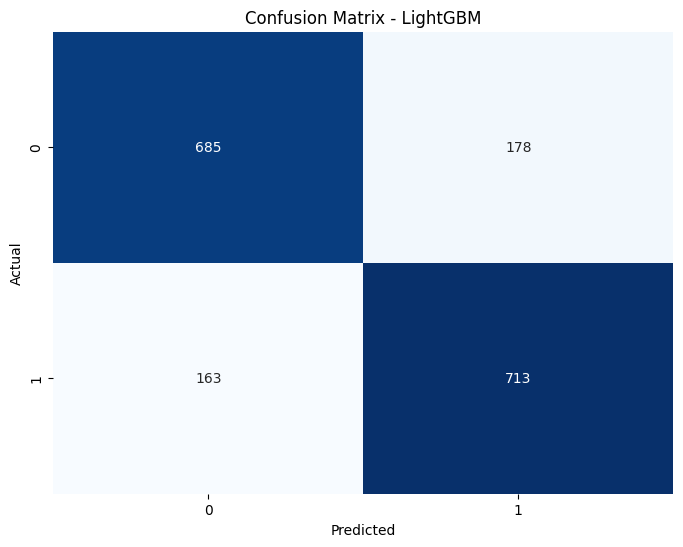

In [28]:
# Calculate and plot confusion matrix
cm = confusion_matrix(y_val_np, y_val_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

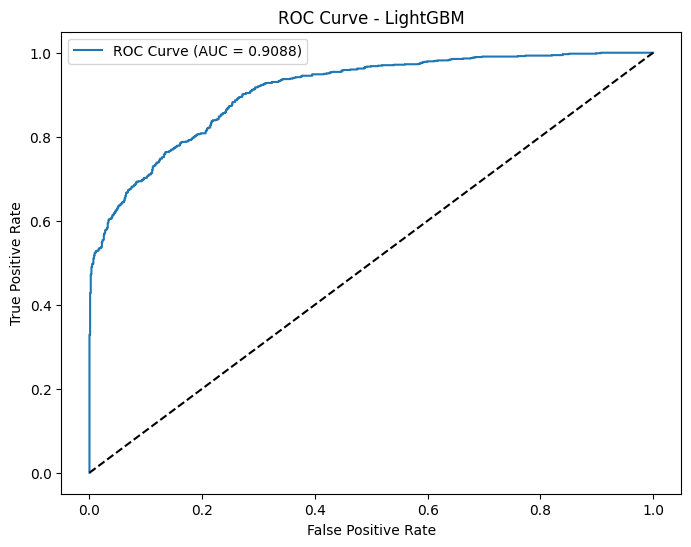

In [29]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val_np, y_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.show()


Calculating learning curve to check for overfitting/underfitting...


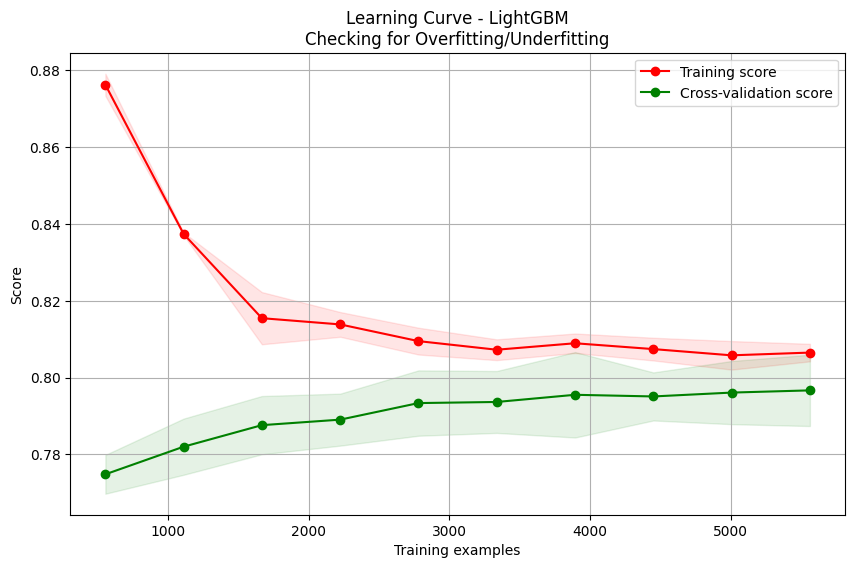

In [30]:
# Learning curve to check for overfitting/underfitting
print("\nCalculating learning curve to check for overfitting/underfitting...")

# Define a simpler LightGBM model for faster learning curve calculation
simple_lgb = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    random_state=RANDOM_STATE
)

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    simple_lgb, X_train, y_train_array, cv=5,
    scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g',
         label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve - LightGBM\nChecking for Overfitting/Underfitting')
plt.legend(loc='best')
plt.grid()
plt.show()


Analyzing feature importance...


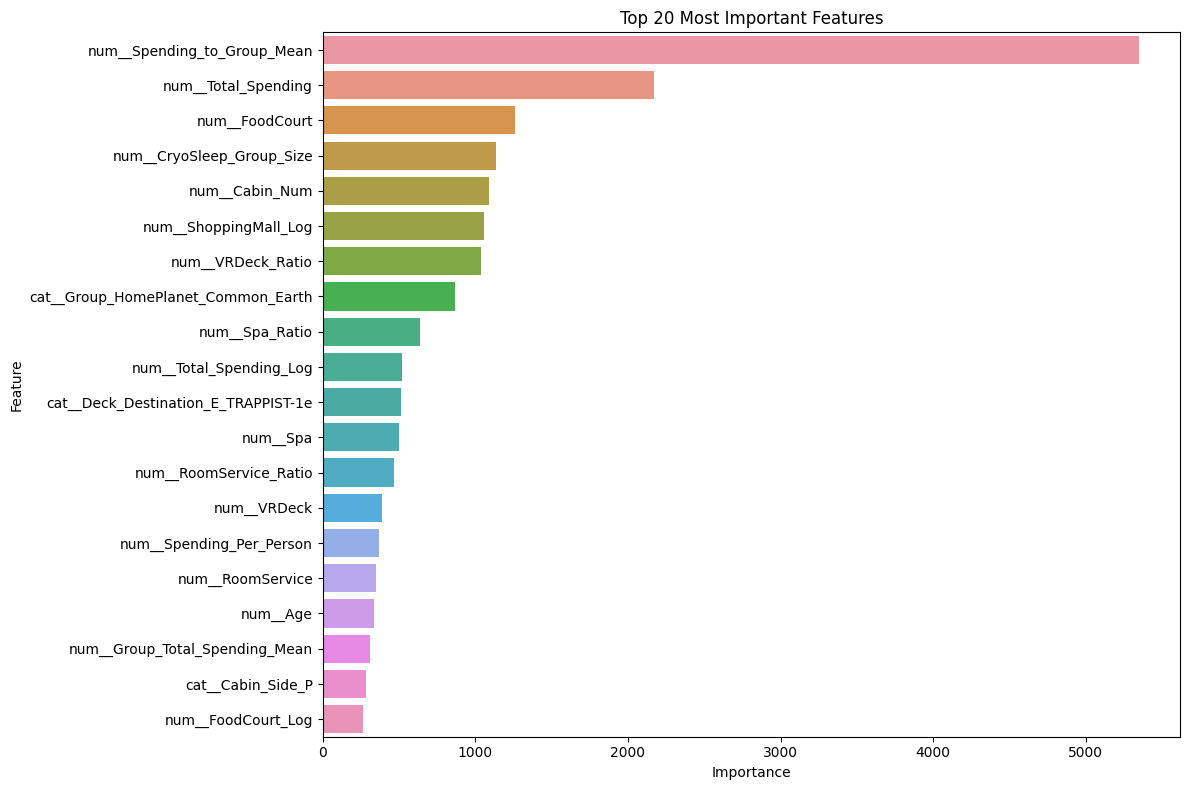

In [31]:
# Feature importance analysis
print("\nAnalyzing feature importance...")

# Get feature importance from the model using LightGBM's built-in methods
feature_importance = final_model.feature_importance(importance_type='gain')

# Get feature names (if available) or generate them
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    num_feature_names = [f'num_{feat}' for feat in numerical_features]
    cat_feature_names = [f'cat_{i}' for i in range(
        X_train.shape[1] - len(num_feature_names))]
    feature_names = np.array(num_feature_names + cat_feature_names)

if len(feature_names) > X_train_selected.shape[1]:
    selected_indices = selector.get_support(indices=True)
    feature_names = feature_names[selected_indices]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importance)],
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

In [32]:
# Make predictions with the model
test_predictions = final_model.predict(X_test_selected)
test_predictions_binary = (test_predictions > 0.5).astype(bool)

# Create submission dataframe
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': test_predictions_binary
})

# Save predictions to a CSV file
submission.to_csv('lgbm_submission.csv', index=False)

print("\nPredictions for test data saved to 'lgbm_submission.csv'")


Predictions for test data saved to 'lgbm_submission.csv'


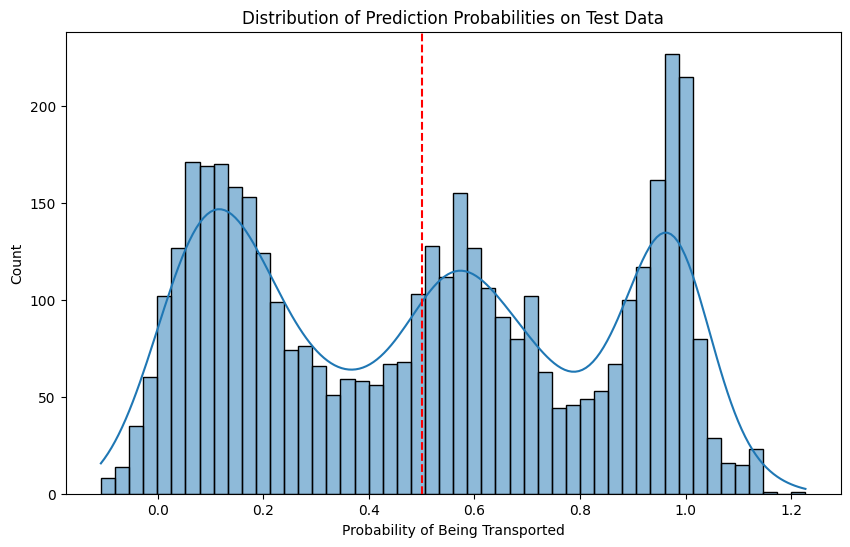

In [33]:
# Visualize prediction probabilities
plt.figure(figsize=(10, 6))
sns.histplot(test_predictions, bins=50, kde=True)
plt.axvline(x=0.5, color='red', linestyle='--')
plt.title('Distribution of Prediction Probabilities on Test Data')
plt.xlabel('Probability of Being Transported')
plt.ylabel('Count')
plt.show()